## Price, Demand and Profit Analysis in Beverage Category for a Food Delivery Company

### MSBA - BUS514 Analytics for Marketing Decision - Group Project

#### Jerry Chen, Jenny Zhang, Xuemeng Wu

Github: https://github.com/jerrychens/food_delivery

## 1 Objectives

Our client is a meal delivery company in India. They have 77 centers to deliver meal orders to customers. The main purpose of our analysis is to identify the portfolio of beverage products and helps the company determine the best price of the products to maximize the profits. Our objective is to investigate and answer the following business questions:

1. What is the price-demand interaction for the beverages in the same cuisine category?

2. What are the major factors to predict the demand for the beverage?

3. What is the optimal price of beverages to maximize the profit?

<img src="img/fooddelivery.png">

## 2 Dataset

- **Data Source:** Our dataset is from Analytics Vidhya, a data science community allowing enthusiasts around the world to learn and advance their skills. The dataset we chose comes from the Hackathons section. We selected the food delivery business dataset (https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/) to conduct the empirical price-demand-profitability analysis.


- **Data Selecion:** The original dataset contains three tables, "Weekly Demand data (train.csv)", "meal_info.csv", "fulfilment_center_info.csv". For the purpose of our project, we only used the first two tables. Table 3 "fulfilment_center_info.csv" contains the information for each fulfillment center, which is irrelevant to our study.


- **Data Description:** 

    - **Table 1. Weekly Demand data (train.csv):** it contains the historical demand data aggregated by week. There are 77 different fulfillment centers, and most of the centers have up to 145 weeks of data. Table 1 contains 456,548 records and 9 columns. The variables are the following:
        - ***id:*** Unique ID
        - ***week:*** Week No.
        - ***center_id:*** Unique ID for fulfillment center
        - ***meal_id:*** Unique ID for meal
        - ***checkout_price:*** Final price including discount, taxed, and delivery charges
        - ***base_price:*** Base price of the meal
        - ***emailer_for_promotion:*** Emailer sent for promotion of meal
        - ***homepage_featured:*** Meal featured at homepage
        - ***num_orders:*** Orders count
    - **Table 2:** meal_info.csv: it contains information for each meal being served. The company has 51 different meals in different categories and cuisine. The variables are as following:

        - ***meal_id:*** Unique ID for the meal
        - ***category:*** Type of meal (beverages/snacks/soups...)
        - ***cuisine:*** Meal cuisine (Indian/Italian...)


## 3 Import Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import expon
from scipy.optimize import Bounds
from scipy.optimize import minimize

## 4 Data Pre-processing and Exploratory Analysis

### 4.1 Data Pre-processing 

#### Step 1: Import and look at the data

In [2]:
# import the data
sales = pd.read_csv('data/train.csv')
meal_info = pd.read_csv('data/meal_info.csv')

In [3]:
sales.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [4]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [5]:
sales.describe() # we want to understand the general discription of the dataset

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [6]:
sales.nunique() # we want to understand the unique values for each columns

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
dtype: int64

In [7]:
meal_info.describe()

,meal_id
count,51.000000
mean,2013.921569
std,553.633555
min,1062.000000
25%,1550.500000
50%,1971.000000
75%,2516.500000
max,2956.000000


**Discussion:** <br>
- There are 456,548 rows and 9 columns in the sales data. The sales data is aggregated by week and fulfillment center. 51 kinds of meals are selling in the past 145 weeks and 77 centers across India. Among all of the meal sales, the mean base price is 354.16, and the mean number of orders is 261.87.
    

#### Step 2: Generate a new variable: the "unit price" of the meal

- In each row, the base price captures the information of the total price of a certain amount of orders. In order to get the unit price of each meal, we added a new column to calculate the `unit_price` using `base_price` dividing by `num_orders`.

In [8]:
sales['unit_price'] = sales['base_price'] / sales['num_orders']

#### Step 3: Eliminate the promoted sales

- In the data, the promoted sales are flagged by the dummy variables "`emailer_for_promotion`" and "`homepage_featured`", where a value of 1 indicates a promoted sales. In order to focus on nonpromoted sales, we filter out rows with no `emailer_for_promotion` and `homepage_featured`.

In [9]:
sales_no_promo = sales[(sales['emailer_for_promotion'] == 0) & (sales['homepage_featured'] == 0)]

#### Step 4: Determine the most meaningful category to look into

- In order to narrow down the scope of our analysis and be more deliverable-oriented, we want to find the most meaningful food category to look into. Considering the purpose of price analysis, it would be better to focus on the category which has greatest price variations. We looked for the `meal_id` with the large `unit_price` variations. We merged two tables to get the meal category information and determined the beverage category has the most price variation among other categories.

In [10]:
# find the meal_id with the most number of different prices by counting the sales rows and the unique price.
sales_no_promo_count = sales_no_promo.groupby('meal_id') ['unit_price'].agg(['count', 'nunique'])
sales_no_promo_count.head()

,count,nunique
meal_id,,
1062,10476,6765
1109,9769,6237
1198,4156,2897
1207,9177,5125
1216,8690,1359


In [11]:
# sort the count with descending order to understand which meal_id have the most price variations
sales_sorted_list = sales_no_promo_count.sort_values(['nunique', 'count'], ascending = False)
sales_sorted_list.head()

,count,nunique
meal_id,,
2707,10344,8160
2290,9865,7972
1062,10476,6765
1109,9769,6237
1885,7906,5972


In [12]:
# merge the meal_info table to understand if the meals' category
sales_sorted_list_meal_info = sales_sorted_list.merge(meal_info, on = 'meal_id', how = 'left')
sales_sorted_list_meal_info.head(15)

,meal_id,count,nunique,category,cuisine
0,2707,10344,8160,Beverages,Italian
1,2290,9865,7972,Rice Bowl,Indian
2,1062,10476,6765,Beverages,Italian
3,1109,9769,6237,Rice Bowl,Indian
4,1885,7906,5972,Beverages,Thai
5,1778,10439,5825,Beverages,Italian
6,1993,7901,5652,Beverages,Thai
7,1754,9357,5624,Sandwich,Italian
8,2322,9235,5622,Beverages,Continental
9,1207,9177,5125,Beverages,Continental


**Discussion:**<br>
- From the table above, the `beverage` category has the most frequent orders, and it has the most price variation among all other categories. We decided to dive deep on `beverage` category to further our price-demand-profitability analysis.

### 4.2 Exploratory Data Analysis

- After we decided to focus on `beverage` category, we wanted to take a look at the price and demand relationship of one beverage to get some intuition for the further analysis. 
- To find the most meanningful beverage to investigate, we digged deeper by looking for the cuisine with the most price variation first, and by looking for the beverage in that cuisine with the most orders as well. By doing that, we found Italian 2707 as our target.

#### Step 1: Find the cuisine with the most price variation

In [13]:
beverages_agg = sales_sorted_list_meal_info[sales_sorted_list_meal_info['category'] == 'Beverages']
beverages_agg

,meal_id,count,nunique,category,cuisine
0,2707,10344,8160,Beverages,Italian
2,1062,10476,6765,Beverages,Italian
4,1885,7906,5972,Beverages,Thai
5,1778,10439,5825,Beverages,Italian
6,1993,7901,5652,Beverages,Thai
8,2322,9235,5622,Beverages,Continental
9,1207,9177,5125,Beverages,Continental
10,1230,9137,5114,Beverages,Continental
11,2539,8466,4897,Beverages,Thai
22,2631,8811,2286,Beverages,Indian


In [14]:
beverages_agg.groupby('cuisine').agg({'count': 'sum', 'nunique': 'sum'}).sort_values('nunique', ascending = False)

,count,nunique
cuisine,,
Italian,31259,20750
Thai,24273,16521
Continental,27549,15861
Indian,26069,5679


**Discussion:**<br>
- Italian beverages have the most price variation, because the number of unique price in Italian cuisine is the highest.
- We also want to find which cuisine type of beverages has the most items (`meal_id`) and orders. We want to confirm if the number of order is correlated with the price variations.
- Indian beverages have fewer price variations, but they have the third popularity among all beverages, which implies that the prices are quite stable in the market.

#### Step 2: Find the cuisine with the most orders and the beverage with the most orders in that cuisine

In [15]:
# revisit the sales_no_promo table
sales_no_promo.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,unit_price
0,1379560,1,55,1885,136.83,152.29,0,0,177,0.860395
1,1466964,1,55,1993,136.83,135.83,0,0,270,0.503074
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.718836
3,1338232,1,55,2139,339.50,437.53,0,0,54,8.102407
4,1448490,1,55,2631,243.50,242.50,0,0,40,6.062500


In [16]:
# drop the checkout_price, checkout_price, emailer_for_promotion, and homepage_featured column to generate a new table 
sales_no_promo_new = sales_no_promo.drop(['checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured'], axis = 1)

In [17]:
# join the meal_info table
sales_no_promo_new_meal = sales_no_promo_new.merge(meal_info, on = 'meal_id', how = 'left')
sales_no_promo_new_meal.head(10)

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
0,1379560,1,55,1885,177,0.860395,Beverages,Thai
1,1466964,1,55,1993,270,0.503074,Beverages,Thai
2,1346989,1,55,2539,189,0.718836,Beverages,Thai
3,1338232,1,55,2139,54,8.102407,Beverages,Indian
4,1448490,1,55,2631,40,6.062500,Beverages,Indian
5,1270037,1,55,1248,28,9.008214,Beverages,Indian
6,1191377,1,55,1778,190,0.970316,Beverages,Italian
7,1499955,1,55,1062,391,0.468951,Beverages,Italian
8,1025244,1,55,2707,472,0.406907,Beverages,Italian
9,1446016,1,55,2290,162,1.916235,Rice Bowl,Indian


In [18]:
# select by "Beverages"
beverages = sales_no_promo_new_meal[sales_no_promo_new_meal['category'] == 'Beverages']
beverages.head()

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
0,1379560,1,55,1885,177,0.860395,Beverages,Thai
1,1466964,1,55,1993,270,0.503074,Beverages,Thai
2,1346989,1,55,2539,189,0.718836,Beverages,Thai
3,1338232,1,55,2139,54,8.102407,Beverages,Indian
4,1448490,1,55,2631,40,6.062500,Beverages,Indian


In [19]:
# aggregate the data to see the count of rows, aggregated number of orders and the average unit price
beverages_agg = beverages.groupby(['cuisine','meal_id']).agg({'id': 'count', 'num_orders': 'sum', 'unit_price': 'mean'})
beverages_agg.columns = ['row_count', 'agg_orders', 'agg_mean_unit_price']
beverages_agg

row_count  agg_orders  agg_mean_unit_price
cuisine     meal_id                                            
Continental 1207          9177     1244362             4.983318
            1230          9137     1283079             5.185043
            2322          9235     1544188             3.848370
Indian      1248          8452      613546             4.314582
            2139          8806      376679            12.024167
            2631          8811      785119             3.515936
Italian     1062         10476     4351671             0.620829
            1778         10439     3038046             1.122531
            2707         10344     5229551             0.886662
Thai        1885          7906     4901117             0.465202
            1993          7901     3722632             0.493636
            2539          8466     2217541             1.093980

**Discussion:**<br>
- Each cuisine has the same amount of beverage options (3 options in each cuisine).
- Thai beverages have more price variations but the `row_count` (store-weeks data) are not as many as we expected.  

#### Step 3: An example price-demand study on Italian beverage 2707

- Italian beverage has the most price variation among all four cuisine types, and Italian 2707 has the most orders in that cuisine. We plot a histogram to see the price distribution, and draw the demand curve to see the relationship of price and demand for Italian 2707. 

#### Price variation histogram for Italian 2707

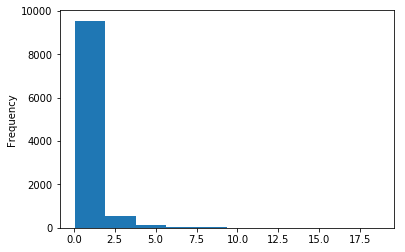

In [20]:
# price histogram
beverages[beverages['meal_id'] == 2707]['unit_price'].plot(kind = 'hist')
plt.show()

#### Demand curve for Italian 2707

In [21]:
# count unique center id
sales_no_promo_new_meal[sales_no_promo_new_meal['meal_id'] == 2707]['center_id'].nunique()

77

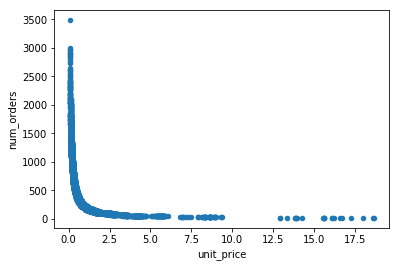

In [22]:
# treat `center_id` as categorical (string) rather than numerical
# sales_no_promo_new_meal['center_id'] = sales_no_promo_new_meal['center_id'].astype('category')

# demand curve
sales_no_promo_new_meal[sales_no_promo_new_meal['meal_id'] == 2707].plot('unit_price','num_orders', kind = 'scatter')

**Discussion:**<br>
- The demand curve of Italian 2707 looks as we expected: lower pirce has higher demand. Later in the price elasticity part, we will expand the demand analysis to all cuisine beverages.

#### Step 4: Check if there is repetitive `meal_id` in the store-weeks

- We want to know if the `meal_id` in each center-week is unique to make sure the data is aggregated by center and week properly.

In [23]:
# if it si true than the unique count matches with the count of the meal_id by week and center_id
# i.e., no repetive meal_id in store-weeks
sum(beverages.groupby(['week','center_id'])['meal_id'].nunique().to_numpy() \
    == beverages.groupby(['week','center_id'])['meal_id'].count().to_numpy()) \
== len(beverages.groupby(['week','center_id'])['meal_id'].nunique().to_numpy())

True

**Discussion:**<br>
- There is no repetitive `meal_id` in the store weeks

## 5 Own & Cross Price Elasticity Analysis

### Step 1: Determine which beverages in each cuisine should we include in our price elasticity analysis

- In order to determine which products should be included in our price elasticity analysis, we calculated the revenue of each beverage and sorted them to find the beverages that have a contribution to the total revenue. We wanted to what are the products contributing to 80% of the total revenue of each cuisine.
- "`cuisine_top_id`" shows the `meal_id` in descending order by revenue, and we calculated the cumulative percentage in the following analysis.

In [24]:
# determine the formula of revenue
beverages_agg['revenue'] = beverages_agg['agg_orders'] * beverages_agg['agg_mean_unit_price']

In [25]:
# calculate the total revenue of each cuisine
cuisine_total = beverages_agg.groupby('cuisine')['revenue'].sum()
cuisine_total

cuisine
Continental    1.879648e+07
Indian         9.936874e+06
Italian        1.074879e+07
Thai           6.543584e+06
Name: revenue, dtype: float64

#### Continental

In [26]:
# find the top 3 beverages in Continental cuisine with the cumulative revenue at least 80% of total revenue of Continental
continental = beverages_agg.loc['Continental'].div(cuisine_total['Continental'], axis = 'revenue')
continental.rename(columns = {'revenue':'pct_revenue'}, inplace = True)
continental_sort = continental.sort_values('pct_revenue', ascending = False)
continental_sort['cum_pct_revenue'] = continental_sort['pct_revenue'].cumsum()
continental_sort.reset_index(inplace = True)
continental_sort

,meal_id,row_count,agg_orders,agg_mean_unit_price,pct_revenue,cum_pct_revenue
0,1230,0.000486,0.068262,2.758519e-07,0.353940,0.353940
1,1207,0.000488,0.066202,2.651198e-07,0.329905,0.683845
2,2322,0.000491,0.082153,2.047389e-07,0.316155,1.000000


In [27]:
continental_top_id = list(continental_sort['meal_id'].values)
continental_top_id

[1230, 1207, 2322]

#### Indian

In [28]:
# find the top 3 beverages in Indian cuisine with the cumulative revenue at least 80% of total revenue of Indian
indian = beverages_agg.loc['Indian'].div(cuisine_total['Indian'], axis = 'revenue')
indian.rename(columns = {'revenue':'pct_revenue'}, inplace = True)
indian_sort = indian.sort_values('pct_revenue', ascending = False)
indian_sort['cum_pct_revenue'] = indian_sort['pct_revenue'].cumsum()
indian_sort.reset_index(inplace = True)
indian_sort

,meal_id,row_count,agg_orders,agg_mean_unit_price,pct_revenue,cum_pct_revenue
0,2139,0.000886,0.037907,1.210055e-06,0.455802,0.455802
1,2631,0.000887,0.079011,3.538272e-07,0.277796,0.733599
2,1248,0.000851,0.061744,4.341991e-07,0.266401,1.000000


In [29]:
indian_top_id = list(indian_sort['meal_id'].values)
indian_top_id

[2139, 2631, 1248]

#### Italian

In [30]:
# find the top 3 beverages in Italian cuisine with the cumulative revenue at least 80% of total revenue of Italian
italian = beverages_agg.loc['Italian'].div(cuisine_total['Italian'], axis = 'revenue')
italian.rename(columns = {'revenue':'pct_revenue'}, inplace = True)
italian_sort = italian.sort_values('pct_revenue', ascending = False)
italian_sort['cum_pct_revenue'] = italian_sort['pct_revenue'].cumsum()
italian_sort.reset_index(inplace = True)
italian_sort

,meal_id,row_count,agg_orders,agg_mean_unit_price,pct_revenue,cum_pct_revenue
0,2707,0.000962,0.486525,8.248950e-08,0.431383,0.431383
1,1778,0.000971,0.282641,1.044333e-07,0.317273,0.748656
2,1062,0.000975,0.404852,5.775803e-08,0.251344,1.000000


In [31]:
italian_top_id = list(italian_sort['meal_id'].values)
italian_top_id

[2707, 1778, 1062]

#### Thai

In [32]:
# find the top 3 beverages in Thai cuisine with the cumulative revenue at least 80% of total revenue of Thai
thai = beverages_agg.loc['Thai'].div(cuisine_total['Thai'], axis = 'revenue')
thai.rename(columns = {'revenue':'pct_revenue'}, inplace = True)
thai_sort = thai.sort_values('pct_revenue', ascending = False)
thai_sort['cum_pct_revenue'] = thai_sort['pct_revenue'].cumsum()
thai_sort.reset_index(inplace = True)
thai_sort

,meal_id,row_count,agg_orders,agg_mean_unit_price,pct_revenue,cum_pct_revenue
0,2539,0.001294,0.338888,1.671836e-07,0.370737,0.370737
1,1885,0.001208,0.748996,7.109291e-08,0.348435,0.719171
2,1993,0.001207,0.568898,7.543823e-08,0.280829,1.000000


In [33]:
thai_top_id = list(thai_sort['meal_id'].values)
thai_top_id

[2539, 1885, 1993]

**Discussion:**<br>
- We originally tried to find the top 3 products in each cuisine with the cumulative revenue at least 80% of total revenue of that cuisine type. However, surprisingly we found there are only 3 products in each cuisine, so that we include them all in our later price elasticity analysis. Since we don't have the information about the actual name of the product, we will use the corresponding `meal_id` to represent the product. 
    - For Continental cuisine, 3 beverages are: 1230, 1207, 2322.
    - For Indian cuisine, 3 beverages are: 2139, 2631, 1248.
    - For Italian cuisine, 3 beverages are: 2707, 1778, 1062.
    - For Thai cuisine, 3 beverages are: 2539, 1885, 1993.

### Step 2: Draw demand curve of each cuisine

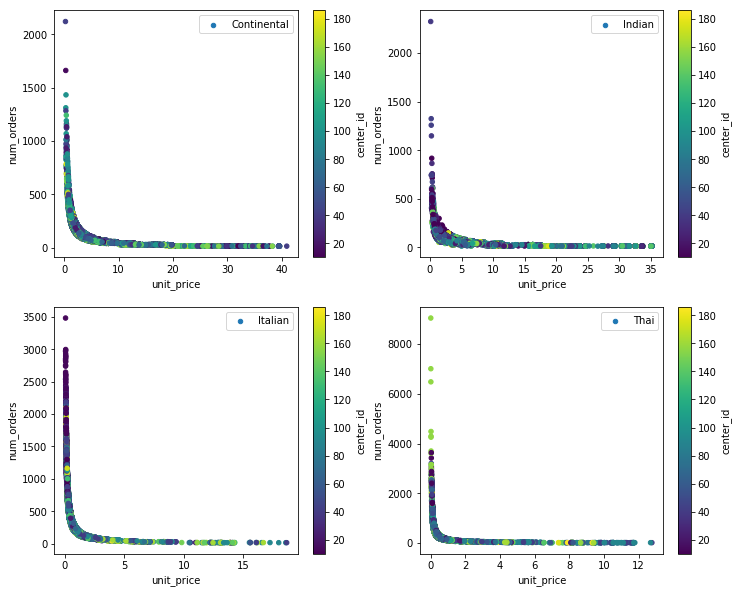

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
beverages[beverages['meal_id'].isin(continental_top_id)].plot('unit_price','num_orders', label='Continental', c= 'center_id', colormap='viridis', kind = 'scatter', ax=axes[0,0])
beverages[beverages['meal_id'].isin(indian_top_id)].plot('unit_price','num_orders', label='Indian', c= 'center_id', colormap='viridis', kind = 'scatter', ax=axes[0,1])
beverages[beverages['meal_id'].isin(italian_top_id)].plot('unit_price','num_orders', label='Italian', c= 'center_id', colormap='viridis', kind = 'scatter', ax=axes[1,0])
beverages[beverages['meal_id'].isin(thai_top_id)].plot('unit_price','num_orders', label='Thai', c= 'center_id', colormap='viridis', kind = 'scatter', ax=axes[1,1])
fig.savefig('img/demand_curve.png')

**Discussion:**<br>
- Customers respond consistently to the price regardless of the product differences in the same cuisine type. 
- Indian beverages have a thicker line, which means they have more demand variations at a given price. That is to say, customers likely to be more bearable to the price change of Indian beverages. 
- Continental also has more variability of demand response for different beverages than Thai beverages.

### Step 3: Conduct price elasticity analysis in each cuisine

- We started from Continental cuisine. The main steps we took can be concluded as:
    - Step 1: we create a new and clean table which contains the information of all beverages in a certain cuisine.
    - Step 2: we drop the NA values because MLR (multiple linear regression) won't take regression with NA. Also, it doesn't make sense to fill the NA value because it may be price variation between weeks for a given center, and we cannot know the demand. Since we have enoguh data, we dropped the rows with NA.
    - Step 3: In order to consider multiple price for a given center-weeks, we need to pivot the original data to a new format to show different prices and demands of different product for a given center-weeks. We rename the columns from the multiple-indexed columns with a new column name followed by the fashion of (`unit_price/num_orders`)\_(meal_id). By doing so, we can flatten the multi-indexed column names into a simple column name for us to do further analysis. 
    - Step 4: we conduct the MLR analysis to build the regression model with only price information.
    - Step 5: we furtherly use `statsmodels.api as sm` instead of the `sklearn` to capture the significance of variables. 
    - Step 5: we change the simple model (just price in the same cuisine) to a more complicated model, which contains the `week` and `C(center_id)`. 
- We found out that the model with more variables can give us more reasonable signs of elasticity. We applied the same model into the other 3 cusines to explore the own and cross price elasticity of each cuisine.

### Continental

In [35]:
# recall the beverages we would like to analyze 
continental_top_id

[1230, 1207, 2322]

In [36]:
# create a clean table which contains the information of Continental beverages
continental_data = beverages[beverages['meal_id'].isin(continental_top_id)]
continental_data.head()

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
33,1372248,1,24,1207,256,1.485430,Beverages,Continental
34,1292501,1,24,1230,243,1.604938,Beverages,Continental
35,1346854,1,24,2322,324,1.194722,Beverages,Continental
72,1039023,1,11,1230,391,0.972634,Beverages,Continental
73,1483315,1,11,2322,513,0.746998,Beverages,Continental


In [37]:
# pivot the original table
continental_pivot = pd.pivot_table(continental_data,
                   values=['num_orders', 'unit_price'], index=['week', 'center_id'],
                   columns=['meal_id'], 
                   aggfunc={'num_orders': np.sum,'unit_price': np.mean})
continental_pivot.head()

num_orders               unit_price                    
meal_id              1207   1230   2322       1207      1230      2322
week center_id                                                        
1    10             769.0  324.0  717.0   0.496983  1.182747  0.538480
     11               NaN  391.0  513.0        NaN  0.972634  0.746998
     13             366.0  337.0  528.0   1.044372  1.157270  0.723939
     17               NaN  175.0    NaN        NaN  2.217143       NaN
     20             203.0  404.0    NaN   1.849212  0.965347       NaN

In [38]:
# drop the rows with NaN values 
continental_pivot_clean = continental_pivot.dropna()

In [39]:
# reset the index to make week as a new column and a row number
continental_pivot_clean.columns = continental_pivot_clean.columns.map(lambda x: '_'.join([str(i) for i in x]))
continental_pivot_clean_complete = continental_pivot_clean.reset_index()
continental_pivot_clean_complete.head()

,week,center_id,num_orders_1207,num_orders_1230,num_orders_2322,unit_price_1207,unit_price_1230,unit_price_2322
0,1,10,769.0,324.0,717.0,0.496983,1.182747,0.538480
1,1,13,366.0,337.0,528.0,1.044372,1.157270,0.723939
2,1,24,256.0,243.0,324.0,1.485430,1.604938,1.194722
3,1,29,42.0,94.0,95.0,7.690714,3.343404,3.155684
4,1,32,53.0,135.0,82.0,5.948113,2.349556,3.963171


- Start with Continental 1207 beverage

In [40]:
# build model with only prices of beverages in the same cuisine using sklearn
X = np.log(continental_pivot_clean_complete[['unit_price_1207','unit_price_1230','unit_price_2322']])
Y = np.log(continental_pivot_clean_complete['num_orders_1207'])
mlr = LinearRegression()
mlr.fit(X, Y)
mlr.coef_

array([-0.9425044 ,  0.06779322, -0.02517644])

In [41]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        num_orders_1207   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 7.063e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        02:44:30   Log-Likelihood:                 4491.1
No. Observations:                8439   AIC:                            -8974.
Df Residuals:                    8435   BIC:                            -8946.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.7564      0.003   18

C:\Users\jerry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [42]:
# build model with week and prices of beverages in the same cuisine using sklearn
X = pd.concat([continental_pivot_clean_complete['week'], np.log(continental_pivot_clean_complete[['unit_price_1207','unit_price_1230','unit_price_2322']])], axis=1, sort=False)
Y = np.log(continental_pivot_clean_complete['num_orders_1207'])
mlr = LinearRegression()
mlr.fit(X, Y)
mlr.coef_

array([ 3.66006888e-04, -9.43216085e-01,  6.77085195e-02, -2.64385519e-02])

In [43]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        num_orders_1207   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 5.360e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        02:44:30   Log-Likelihood:                 4539.3
No. Observations:                8439   AIC:                            -9069.
Df Residuals:                    8434   BIC:                            -9033.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.7317      0.004   14

C:\Users\jerry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [44]:
# take log of all price and orders variables
continental_pivot_clean_complete[['log_num_orders_1207','log_num_orders_1230','log_num_orders_2322','log_unit_price_1207', 'log_unit_price_1230', 'log_unit_price_2322']] = \
continental_pivot_clean_complete[['num_orders_1207','num_orders_1230','num_orders_2322','unit_price_1207', 'unit_price_1230', 'unit_price_2322']].apply(np.log)
continental_pivot_clean_complete.head()

,week,center_id,num_orders_1207,num_orders_1230,num_orders_2322,unit_price_1207,unit_price_1230,unit_price_2322,log_num_orders_1207,log_num_orders_1230,log_num_orders_2322,log_unit_price_1207,log_unit_price_1230,log_unit_price_2322
0,1,10,769.0,324.0,717.0,0.496983,1.182747,0.538480,6.645091,5.780744,6.575076,-0.699199,0.167840,-0.619005
1,1,13,366.0,337.0,528.0,1.044372,1.157270,0.723939,5.902633,5.820083,6.269096,0.043415,0.146064,-0.323048
2,1,24,256.0,243.0,324.0,1.485430,1.604938,1.194722,5.545177,5.493061,5.780744,0.395704,0.473085,0.177914
3,1,29,42.0,94.0,95.0,7.690714,3.343404,3.155684,3.737670,4.543295,4.553877,2.040014,1.206990,1.149205
4,1,32,53.0,135.0,82.0,5.948113,2.349556,3.963171,3.970292,4.905275,4.406719,1.783074,0.854226,1.377044


In [45]:
# build model with week and prices of beverages in the same cuisine using `statsmodel`
from statsmodels.formula.api import ols

fit_cont_1207 = ols('log_num_orders_1207 ~ log_unit_price_1207 + log_unit_price_1230 + log_unit_price_2322 + week + C(center_id)', data = continental_pivot_clean_complete).fit() 

fit_cont_1207.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1207   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                     8388.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:30   Log-Likelihood:                 9281.4
No. Observations:                 8439   AIC:                        -1.840e+04
Df Residuals:                     8358   BIC:                        -1.783e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.9260      0.008    737.419      0.000       5.910       5.942
C(center_id)[T.11]      0.0040      0.011      0.371      0.710      -0.017       0.025
C(center_id)[T.13]     -0.0014      0.011     -0.135      0.892      -0.022       0.020
C(center_id)[T.14]      0.0131      0.011      1.227      0.220      -0.008       0.034
C(center_id)[T.17]     -0.0491      0.011     -4.417      0.000      -0.071      -0.027
C(center_id)[T.20]     -0.0610      0.011     -5.379      0.000      -0.083      -0.039
C(center_id)[T.23]     -0.0085      0.011     -0.777      0.437      -0.030       0.013
C(center_id)[T.24]      0.0050      0.011      0.439      0.661      -0.017       0.027
C(center_id)[T.26]     -0.2312      0.011    -21.848      0.000      -0.252      -0.210
C(center_id)[T.27]     -0.0120      0.011     -1.096      0.273      -0.033       0.009
C(center_id)[T.29]     -0.2567      0.011    -23.472      0.000      -0.278      -0.235
C(center_id)[T.30]     -0.0098      0.011     -0.891      0.373      -0.031       0.012
C(center_id)[T.32]     -0.2399      0.010    -22.929      0.000      -0.260      -0.219
C(center_id)[T.34]     -0.3060      0.011    -28.826      0.000      -0.327      -0.285
C(center_id)[T.36]     -0.0549      0.011     -5.010      0.000      -0.076      -0.033
C(center_id)[T.39]     -0.2576      0.011    -23.996      0.000      -0.279      -0.237
C(center_id)[T.41]     -0.0327      0.011     -3.013      0.003      -0.054      -0.011
C(center_id)[T.42]     -0.3092      0.011    -29.000      0.000      -0.330      -0.288
C(center_id)[T.43]      0.0279      0.011      2.568      0.010       0.007       0.049
C(center_id)[T.50]     -0.2559      0.011    -23.585      0.000      -0.277      -0.235
C(center_id)[T.51]     -0.0095      0.011     -0.864      0.388      -0.031       0.012
C(center_id)[T.52]     -0.0239      0.011     -2.177      0.030      -0.045      -0.002
C(center_id)[T.53]     -0.0583      0.011     -5.119      0.000      -0.081      -0.036
C(center_id)[T.55]     -0.0279      0.011     -2.545      0.011      -0.049      -0.006
C(center_id)[T.57]     -0.2281      0.013    -17.580      0.000      -0.254      -0.203
C(center_id)[T.58]     -0.2388      0.011    -22.600      0.000      -0.260      -0.218
C(center_id)[T.59]     -0.0385      0.011     -3.449      0.001      -0.060      -0.017
C(center_id)[T.61]     -0.2761      0.011    -25.624      0.000      -0.297      -0.255
C(center_id)[T.64]     -0.2856      0.012    -23.380      0.000      -0.310      -0.262
C(center_id)[T.65]     -0.2272      0.011    -21.392      0.000      -0.248      -0.206
C(center_id)[T.66]     -0.2254      0.010    -21.667      0.000      -0.246      -0.205
C(center_id)[T.67]     -0.0255      0.011     -2.291      0.022      -0.047     

- Investigate Continental 1230 and 2322 beverages as following

In [46]:
# build model with week and prices of beverages in the same cuisine using `statsmodel`
fit_cont_1230 = ols('log_num_orders_1230 ~ log_unit_price_1230 + log_unit_price_1207 + log_unit_price_2322 + week + C(center_id)', data = continental_pivot_clean_complete).fit() 

fit_cont_1230.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1230   R-squared:                       0.990
Model:                             OLS   Adj. R-squared:                  0.989
Method:                  Least Squares   F-statistic:                     9938.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:31   Log-Likelihood:                 9494.8
No. Observations:                 8439   AIC:                        -1.883e+04
Df Residuals:                     8358   BIC:                        -1.826e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.9126      0.008    754.593      0.000       5.897       5.928
C(center_id)[T.11]      0.0083      0.011      0.783      0.434      -0.012       0.029
C(center_id)[T.13]      0.0227      0.010      2.175      0.030       0.002       0.043
C(center_id)[T.14]      0.0126      0.010      1.207      0.227      -0.008       0.033
C(center_id)[T.17]     -0.0286      0.011     -2.637      0.008      -0.050      -0.007
C(center_id)[T.20]     -0.0534      0.011     -4.832      0.000      -0.075      -0.032
C(center_id)[T.23]      0.0062      0.011      0.575      0.565      -0.015       0.027
C(center_id)[T.24]      0.0089      0.011      0.799      0.424      -0.013       0.031
C(center_id)[T.26]     -0.2101      0.010    -20.357      0.000      -0.230      -0.190
C(center_id)[T.27]      0.0049      0.011      0.458      0.647      -0.016       0.026
C(center_id)[T.29]     -0.2437      0.011    -22.848      0.000      -0.265      -0.223
C(center_id)[T.30]      0.0027      0.011      0.249      0.803      -0.018       0.024
C(center_id)[T.32]     -0.2265      0.010    -22.207      0.000      -0.247      -0.207
C(center_id)[T.34]     -0.2929      0.010    -28.298      0.000      -0.313      -0.273
C(center_id)[T.36]     -0.0241      0.011     -2.254      0.024      -0.045      -0.003
C(center_id)[T.39]     -0.2449      0.010    -23.396      0.000      -0.265      -0.224
C(center_id)[T.41]     -0.0089      0.011     -0.844      0.399      -0.030       0.012
C(center_id)[T.42]     -0.2845      0.010    -27.367      0.000      -0.305      -0.264
C(center_id)[T.43]      0.0300      0.011      2.834      0.005       0.009       0.051
C(center_id)[T.50]     -0.2294      0.011    -21.681      0.000      -0.250      -0.209
C(center_id)[T.51]     -0.0183      0.011     -1.714      0.087      -0.039       0.003
C(center_id)[T.52]     -0.0004      0.011     -0.036      0.972      -0.021       0.021
C(center_id)[T.53]     -0.0533      0.011     -4.799      0.000      -0.075      -0.032
C(center_id)[T.55]     -0.0170      0.011     -1.592      0.111      -0.038       0.004
C(center_id)[T.57]     -0.2094      0.013    -16.548      0.000      -0.234      -0.185
C(center_id)[T.58]     -0.2274      0.010    -22.071      0.000      -0.248      -0.207
C(center_id)[T.59]     -0.0396      0.011     -3.637      0.000      -0.061      -0.018
C(center_id)[T.61]     -0.2644      0.011    -25.169      0.000      -0.285      -0.244
C(center_id)[T.64]     -0.2705      0.012    -22.709      0.000      -0.294      -0.247
C(center_id)[T.65]     -0.2097      0.010    -20.246      0.000      -0.230      -0.189
C(center_id)[T.66]     -0.2163      0.010    -21.322      0.000      -0.236      -0.196
C(center_id)[T.67]     -0.0193      0.011     -1.782      0.075      -0.041     

In [47]:
# # build model with week and prices of beverages in the same cuisine using `statsmodel`
fit_cont_2322 = ols('log_num_orders_2322 ~ log_unit_price_2322 + log_unit_price_1207 + log_unit_price_1230 + week + C(center_id)', data = continental_pivot_clean_complete).fit() 

fit_cont_2322.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_2322   R-squared:                       0.987
Model:                             OLS   Adj. R-squared:                  0.987
Method:                  Least Squares   F-statistic:                     8162.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:31   Log-Likelihood:                 9462.8
No. Observations:                 8439   AIC:                        -1.876e+04
Df Residuals:                     8358   BIC:                        -1.819e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.9102      0.008    751.434      0.000       5.895       5.926
C(center_id)[T.11]      0.0087      0.011      0.815      0.415      -0.012       0.030
C(center_id)[T.13]      0.0044      0.010      0.425      0.671      -0.016       0.025
C(center_id)[T.14]      0.0156      0.010      1.488      0.137      -0.005       0.036
C(center_id)[T.17]     -0.0131      0.011     -1.207      0.227      -0.034       0.008
C(center_id)[T.20]     -0.0542      0.011     -4.884      0.000      -0.076      -0.032
C(center_id)[T.23]      0.0014      0.011      0.127      0.899      -0.020       0.022
C(center_id)[T.24]      0.0185      0.011      1.646      0.100      -0.004       0.040
C(center_id)[T.26]     -0.2042      0.010    -19.717      0.000      -0.225      -0.184
C(center_id)[T.27]      0.0181      0.011      1.686      0.092      -0.003       0.039
C(center_id)[T.29]     -0.2360      0.011    -22.046      0.000      -0.257      -0.215
C(center_id)[T.30]      0.0079      0.011      0.737      0.461      -0.013       0.029
C(center_id)[T.32]     -0.2219      0.010    -21.666      0.000      -0.242      -0.202
C(center_id)[T.34]     -0.2799      0.010    -26.946      0.000      -0.300      -0.260
C(center_id)[T.36]     -0.0452      0.011     -4.216      0.000      -0.066      -0.024
C(center_id)[T.39]     -0.2468      0.011    -23.490      0.000      -0.267      -0.226
C(center_id)[T.41]     -0.0127      0.011     -1.198      0.231      -0.034       0.008
C(center_id)[T.42]     -0.2853      0.010    -27.341      0.000      -0.306      -0.265
C(center_id)[T.43]      0.0390      0.011      3.675      0.000       0.018       0.060
C(center_id)[T.50]     -0.2295      0.011    -21.608      0.000      -0.250      -0.209
C(center_id)[T.51]     -0.0044      0.011     -0.409      0.683      -0.025       0.017
C(center_id)[T.52]     -0.0018      0.011     -0.168      0.867      -0.023       0.019
C(center_id)[T.53]     -0.0780      0.011     -7.002      0.000      -0.100      -0.056
C(center_id)[T.55]     -0.0127      0.011     -1.186      0.236      -0.034       0.008
C(center_id)[T.57]     -0.2097      0.013    -16.508      0.000      -0.235      -0.185
C(center_id)[T.58]     -0.2203      0.010    -21.299      0.000      -0.241      -0.200
C(center_id)[T.59]     -0.0508      0.011     -4.648      0.000      -0.072      -0.029
C(center_id)[T.61]     -0.2630      0.011    -24.933      0.000      -0.284      -0.242
C(center_id)[T.64]     -0.2638      0.012    -22.059      0.000      -0.287      -0.240
C(center_id)[T.65]     -0.2066      0.010    -19.874      0.000      -0.227      -0.186
C(center_id)[T.66]     -0.2111      0.010    -20.730      0.000      -0.231      -0.191
C(center_id)[T.67]     -0.0180      0.011     -1.652      0.099      -0.039     

**Discussion:**<br>
- The model with prices of products in the same cuisine, week and C(center_id) is better performance because the signs of the coefficients in this model are more reasonable. Model with less predictors has negtive coefficient on some cross price elasticity, which doesn't make sense normally. 
- All price elasticity are significant.
- The own-price elasticity of 3 Continental beverages are close to 1, and the corss price elasticity of 3 beverages are close to 0. We can infer that the demand of each beverages in Continental cuisine are rarely effected by the prices of other beverages in the same cuisine.

### Indian

In [48]:
indian_data = beverages[beverages['meal_id'].isin(indian_top_id)]
indian_data.head()

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
3,1338232,1,55,2139,54,8.102407,Beverages,Indian
4,1448490,1,55,2631,40,6.062500,Beverages,Indian
5,1270037,1,55,1248,28,9.008214,Beverages,Indian
27,1323742,1,24,2139,55,7.918727,Beverages,Indian
28,1417386,1,24,2631,67,3.707164,Beverages,Indian


In [49]:
indian_pivot = pd.pivot_table(indian_data,
                   values=['num_orders', 'unit_price'], index=['week', 'center_id'],
                   columns=['meal_id'], 
                   aggfunc={'num_orders': np.sum,'unit_price': np.mean})
indian_pivot.head()

num_orders               unit_price                     
meal_id              1248   2139   2631       1248       2139      2631
week center_id                                                         
1    10             177.0  298.0  108.0   1.408418   1.438725  2.335463
     11              27.0   54.0   80.0   9.378889   8.083889  3.140375
     13             121.0  123.0  162.0   2.076281   3.557154  2.700432
     14             123.0   14.0   53.0   2.042520  31.109286  4.668113
     17              15.0   68.0    NaN  16.882000   6.419559       NaN

In [50]:
indian_pivot_clean = indian_pivot.dropna()

In [51]:
indian_pivot_clean.columns = indian_pivot_clean.columns.map(lambda x: '_'.join([str(i) for i in x]))

In [52]:
indian_pivot_clean_complete = indian_pivot_clean.reset_index()
indian_pivot_clean_complete.head()

,week,center_id,num_orders_1248,num_orders_2139,num_orders_2631,unit_price_1248,unit_price_2139,unit_price_2631
0,1,10,177.0,298.0,108.0,1.408418,1.438725,2.335463
1,1,11,27.0,54.0,80.0,9.378889,8.083889,3.140375
2,1,13,121.0,123.0,162.0,2.076281,3.557154,2.700432
3,1,14,123.0,14.0,53.0,2.042520,31.109286,4.668113
4,1,20,67.0,69.0,55.0,3.692239,6.312029,4.586000


In [53]:
indian_pivot_clean_complete[['log_num_orders_1248','log_num_orders_2139','log_num_orders_2631','log_unit_price_1248', 'log_unit_price_2139', 'log_unit_price_2631']] = \
indian_pivot_clean_complete[['num_orders_1248','num_orders_2139','num_orders_2631','unit_price_1248', 'unit_price_2139', 'unit_price_2631']].apply(np.log)
indian_pivot_clean_complete.head()

,week,center_id,num_orders_1248,num_orders_2139,num_orders_2631,unit_price_1248,unit_price_2139,unit_price_2631,log_num_orders_1248,log_num_orders_2139,log_num_orders_2631,log_unit_price_1248,log_unit_price_2139,log_unit_price_2631
0,1,10,177.0,298.0,108.0,1.408418,1.438725,2.335463,5.176150,5.697093,4.682131,0.342467,0.363757,0.848210
1,1,11,27.0,54.0,80.0,9.378889,8.083889,3.140375,3.295837,3.988984,4.382027,2.238461,2.089873,1.144342
2,1,13,121.0,123.0,162.0,2.076281,3.557154,2.700432,4.795791,4.812184,5.087596,0.730578,1.268961,0.993412
3,1,14,123.0,14.0,53.0,2.042520,31.109286,4.668113,4.812184,2.639057,3.970292,0.714184,3.437506,1.540755
4,1,20,67.0,69.0,55.0,3.692239,6.312029,4.586000,4.204693,4.234107,4.007333,1.306233,1.842457,1.523008


In [54]:
fit_ind_1248 = ols('log_num_orders_1248 ~ log_unit_price_1248 + log_unit_price_2139 + log_unit_price_2631 + week + C(center_id)', data = indian_pivot_clean_complete).fit() 

fit_ind_1248.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1248   R-squared:                       0.969
Model:                             OLS   Adj. R-squared:                  0.968
Method:                  Least Squares   F-statistic:                     2565.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:31   Log-Likelihood:                 3803.8
No. Observations:                 6434   AIC:                            -7452.
Df Residuals:                     6356   BIC:                            -6924.
Df Model:                           77                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.2355      0.013    399.235      0.000       5.210       5.261
C(center_id)[T.11]     -0.1312      0.018     -7.425      0.000      -0.166      -0.097
C(center_id)[T.13]     -0.0329      0.018     -1.873      0.061      -0.067       0.002
C(center_id)[T.14]     -0.1478      0.021     -7.191      0.000      -0.188      -0.108
C(center_id)[T.17]     -0.2487      0.020    -12.624      0.000      -0.287      -0.210
C(center_id)[T.20]     -0.1715      0.019     -9.192      0.000      -0.208      -0.135
C(center_id)[T.23]     -0.2267      0.020    -11.613      0.000      -0.265      -0.188
C(center_id)[T.24]      0.1187      0.096      1.235      0.217      -0.070       0.307
C(center_id)[T.26]     -0.2346      0.020    -11.655      0.000      -0.274      -0.195
C(center_id)[T.27]     -0.1453      0.018     -8.153      0.000      -0.180      -0.110
C(center_id)[T.29]     -0.2053      0.019    -10.646      0.000      -0.243      -0.167
C(center_id)[T.30]     -0.1981      0.019    -10.307      0.000      -0.236      -0.160
C(center_id)[T.32]     -0.1819      0.019     -9.709      0.000      -0.219      -0.145
C(center_id)[T.34]     -0.2247      0.020    -10.979      0.000      -0.265      -0.185
C(center_id)[T.36]     -0.1836      0.018    -10.007      0.000      -0.220      -0.148
C(center_id)[T.39]     -0.1892      0.019     -9.979      0.000      -0.226      -0.152
C(center_id)[T.42]     -0.2521      0.021    -11.786      0.000      -0.294      -0.210
C(center_id)[T.43]     -0.0229      0.018     -1.305      0.192      -0.057       0.011
C(center_id)[T.50]     -0.1825      0.018    -10.056      0.000      -0.218      -0.147
C(center_id)[T.51]     -0.1253      0.018     -6.886      0.000      -0.161      -0.090
C(center_id)[T.52]     -0.0187      0.017     -1.084      0.278      -0.052       0.015
C(center_id)[T.53]     -0.2217      0.019    -11.458      0.000      -0.260      -0.184
C(center_id)[T.55]     -0.2768      0.021    -13.202      0.000      -0.318      -0.236
C(center_id)[T.57]     -0.2793      0.023    -12.218      0.000      -0.324      -0.234
C(center_id)[T.58]     -0.2337      0.019    -12.147      0.000      -0.271      -0.196
C(center_id)[T.59]     -0.1909      0.020     -9.687      0.000      -0.229      -0.152
C(center_id)[T.61]     -0.2056      0.020    -10.314      0.000      -0.245      -0.166
C(center_id)[T.64]     -0.2448      0.020    -12.482      0.000      -0.283      -0.206
C(center_id)[T.65]     -0.1787      0.020     -8.928      0.000      -0.218      -0.139
C(center_id)[T.66]     -0.1927      0.018    -10.451      0.000      -0.229      -0.157
C(center_id)[T.67]     -0.1554      0.018     -8.655      0.000      -0.191      -0.120
C(center_id)[T.68]     -0.2294      0.020    -11.461      0.000      -0.269     

In [55]:
fit_ind_2139 = ols('log_num_orders_2139 ~ log_unit_price_2139 + log_unit_price_1248 + log_unit_price_2631 + week + C(center_id)', data = indian_pivot_clean_complete).fit() 

fit_ind_2139.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_2139   R-squared:                       0.979
Model:                             OLS   Adj. R-squared:                  0.978
Method:                  Least Squares   F-statistic:                     3760.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:31   Log-Likelihood:                 5747.4
No. Observations:                 6434   AIC:                        -1.134e+04
Df Residuals:                     6356   BIC:                        -1.081e+04
Df Model:                           77                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.8488      0.010    603.283      0.000       5.830       5.868
C(center_id)[T.11]     -0.0806      0.013     -6.171      0.000      -0.106      -0.055
C(center_id)[T.13]     -0.0158      0.013     -1.216      0.224      -0.041       0.010
C(center_id)[T.14]     -0.0956      0.015     -6.295      0.000      -0.125      -0.066
C(center_id)[T.17]     -0.1707      0.015    -11.722      0.000      -0.199      -0.142
C(center_id)[T.20]     -0.1127      0.014     -8.172      0.000      -0.140      -0.086
C(center_id)[T.23]     -0.1466      0.014    -10.158      0.000      -0.175      -0.118
C(center_id)[T.24]      0.0832      0.071      1.171      0.242      -0.056       0.223
C(center_id)[T.26]     -0.1717      0.015    -11.542      0.000      -0.201      -0.143
C(center_id)[T.27]     -0.1159      0.013     -8.799      0.000      -0.142      -0.090
C(center_id)[T.29]     -0.1507      0.014    -10.574      0.000      -0.179      -0.123
C(center_id)[T.30]     -0.1340      0.014     -9.430      0.000      -0.162      -0.106
C(center_id)[T.32]     -0.1196      0.014     -8.633      0.000      -0.147      -0.092
C(center_id)[T.34]     -0.1611      0.015    -10.646      0.000      -0.191      -0.131
C(center_id)[T.36]     -0.1351      0.014     -9.960      0.000      -0.162      -0.109
C(center_id)[T.39]     -0.1272      0.014     -9.073      0.000      -0.155      -0.100
C(center_id)[T.42]     -0.1345      0.016     -8.505      0.000      -0.165      -0.103
C(center_id)[T.43]     -0.0250      0.013     -1.928      0.054      -0.050       0.000
C(center_id)[T.50]     -0.1144      0.013     -8.524      0.000      -0.141      -0.088
C(center_id)[T.51]     -0.1125      0.013     -8.357      0.000      -0.139      -0.086
C(center_id)[T.52]     -0.0441      0.013     -3.468      0.001      -0.069      -0.019
C(center_id)[T.53]     -0.1599      0.014    -11.180      0.000      -0.188      -0.132
C(center_id)[T.55]     -0.1854      0.016    -11.962      0.000      -0.216      -0.155
C(center_id)[T.57]     -0.1939      0.017    -11.475      0.000      -0.227      -0.161
C(center_id)[T.58]     -0.1588      0.014    -11.165      0.000      -0.187      -0.131
C(center_id)[T.59]     -0.1411      0.015     -9.686      0.000      -0.170      -0.113
C(center_id)[T.61]     -0.1365      0.015     -9.264      0.000      -0.165      -0.108
C(center_id)[T.64]     -0.1741      0.014    -12.009      0.000      -0.203      -0.146
C(center_id)[T.65]     -0.1241      0.015     -8.388      0.000      -0.153      -0.095
C(center_id)[T.66]     -0.1278      0.014     -9.372      0.000      -0.154      -0.101
C(center_id)[T.67]     -0.1063      0.013     -8.011      0.000      -0.132      -0.080
C(center_id)[T.68]     -0.1524      0.015    -10.300      0.000      -0.181     

In [56]:
fit_ind_2631 = ols('log_num_orders_2631 ~ log_unit_price_2631 + log_unit_price_1248 + log_unit_price_2139 + week + C(center_id)', data = indian_pivot_clean_complete).fit() 

fit_ind_2631.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_2631   R-squared:                       0.966
Model:                             OLS   Adj. R-squared:                  0.965
Method:                  Least Squares   F-statistic:                     2318.
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:32   Log-Likelihood:                 3759.1
No. Observations:                 6434   AIC:                            -7362.
Df Residuals:                     6356   BIC:                            -6834.
Df Model:                           77                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.2459      0.013    397.253      0.000       5.220       5.272
C(center_id)[T.11]     -0.1347      0.018     -7.568      0.000      -0.170      -0.100
C(center_id)[T.13]     -0.0350      0.018     -1.981      0.048      -0.070      -0.000
C(center_id)[T.14]     -0.1523      0.021     -7.359      0.000      -0.193      -0.112
C(center_id)[T.17]     -0.2546      0.020    -12.836      0.000      -0.294      -0.216
C(center_id)[T.20]     -0.1694      0.019     -9.014      0.000      -0.206      -0.133
C(center_id)[T.23]     -0.2272      0.020    -11.556      0.000      -0.266      -0.189
C(center_id)[T.24]      0.1063      0.097      1.098      0.272      -0.084       0.296
C(center_id)[T.26]     -0.2309      0.020    -11.395      0.000      -0.271      -0.191
C(center_id)[T.27]     -0.1464      0.018     -8.160      0.000      -0.182      -0.111
C(center_id)[T.29]     -0.2007      0.019    -10.338      0.000      -0.239      -0.163
C(center_id)[T.30]     -0.2105      0.019    -10.874      0.000      -0.248      -0.173
C(center_id)[T.32]     -0.1701      0.019     -9.015      0.000      -0.207      -0.133
C(center_id)[T.34]     -0.2250      0.021    -10.913      0.000      -0.265      -0.185
C(center_id)[T.36]     -0.1852      0.018    -10.021      0.000      -0.221      -0.149
C(center_id)[T.39]     -0.1927      0.019    -10.094      0.000      -0.230      -0.155
C(center_id)[T.42]     -0.2409      0.022    -11.184      0.000      -0.283      -0.199
C(center_id)[T.43]     -0.0315      0.018     -1.786      0.074      -0.066       0.003
C(center_id)[T.50]     -0.1798      0.018     -9.834      0.000      -0.216      -0.144
C(center_id)[T.51]     -0.1596      0.018     -8.710      0.000      -0.196      -0.124
C(center_id)[T.52]     -0.0254      0.017     -1.463      0.143      -0.059       0.009
C(center_id)[T.53]     -0.2198      0.019    -11.278      0.000      -0.258      -0.182
C(center_id)[T.55]     -0.2829      0.021    -13.399      0.000      -0.324      -0.242
C(center_id)[T.57]     -0.2801      0.023    -12.169      0.000      -0.325      -0.235
C(center_id)[T.58]     -0.2191      0.019    -11.307      0.000      -0.257      -0.181
C(center_id)[T.59]     -0.1833      0.020     -9.240      0.000      -0.222      -0.144
C(center_id)[T.61]     -0.2037      0.020    -10.148      0.000      -0.243      -0.164
C(center_id)[T.64]     -0.2747      0.020    -13.908      0.000      -0.313      -0.236
C(center_id)[T.65]     -0.1819      0.020     -9.022      0.000      -0.221      -0.142
C(center_id)[T.66]     -0.1874      0.019    -10.091      0.000      -0.224      -0.151
C(center_id)[T.67]     -0.1521      0.018     -8.412      0.000      -0.188      -0.117
C(center_id)[T.68]     -0.2075      0.020    -10.294      0.000      -0.247     

**Discussion:**<br>
- The price elasticity pattern of Indian cuisine is pretty similar with what we see in Continental cuisine. 

### Italian

In [57]:
italian_data = beverages[beverages['meal_id'].isin(italian_top_id)]
italian_data.head()

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
6,1191377,1,55,1778,190,0.970316,Beverages,Italian
7,1499955,1,55,1062,391,0.468951,Beverages,Italian
8,1025244,1,55,2707,472,0.406907,Beverages,Italian
30,1168714,1,24,1778,377,0.476154,Beverages,Italian
31,1351400,1,24,1062,514,0.354786,Beverages,Italian


In [58]:
italian_pivot = pd.pivot_table(italian_data,
                   values=['num_orders', 'unit_price'], index=['week', 'center_id'],
                   columns=['meal_id'], 
                   aggfunc={'num_orders': np.sum,'unit_price': np.mean})
italian_pivot.head()

num_orders                unit_price                    
meal_id              1062   1778    2707       1062      1778      2707
week center_id                                                         
1    10             865.0  742.0  1350.0   0.209699  0.248464  0.145185
     11             798.0  620.0  1594.0   0.228521  0.292565  0.120527
     13             998.0  513.0  2078.0   0.185701  0.355478  0.092921
     14             256.0  243.0   757.0   0.712344  0.762675  0.255073
     17             270.0  190.0   674.0   0.675407  0.954842  0.289318

In [59]:
italian_pivot_clean = italian_pivot.dropna()

In [60]:
italian_pivot_clean.columns = italian_pivot_clean.columns.map(lambda x: '_'.join([str(i) for i in x]))

In [61]:
italian_pivot_clean_complete = italian_pivot_clean.reset_index()
italian_pivot_clean_complete.head()

,week,center_id,num_orders_1062,num_orders_1778,num_orders_2707,unit_price_1062,unit_price_1778,unit_price_2707
0,1,10,865.0,742.0,1350.0,0.209699,0.248464,0.145185
1,1,11,798.0,620.0,1594.0,0.228521,0.292565,0.120527
2,1,13,998.0,513.0,2078.0,0.185701,0.355478,0.092921
3,1,14,256.0,243.0,757.0,0.712344,0.762675,0.255073
4,1,17,270.0,190.0,674.0,0.675407,0.954842,0.289318


In [62]:
italian_pivot_clean_complete[['log_num_orders_1062','log_num_orders_1778','log_num_orders_2707','log_unit_price_1062', 'log_unit_price_1778', 'log_unit_price_2707']] = \
italian_pivot_clean_complete[['num_orders_1062','num_orders_1778','num_orders_2707','unit_price_1062', 'unit_price_1778', 'unit_price_2707']].apply(np.log)
italian_pivot_clean_complete.head()

,week,center_id,num_orders_1062,num_orders_1778,num_orders_2707,unit_price_1062,unit_price_1778,unit_price_2707,log_num_orders_1062,log_num_orders_1778,log_num_orders_2707,log_unit_price_1062,log_unit_price_1778,log_unit_price_2707
0,1,10,865.0,742.0,1350.0,0.209699,0.248464,0.145185,6.762730,6.609349,7.207860,-1.562080,-1.392459,-1.929745
1,1,11,798.0,620.0,1594.0,0.228521,0.292565,0.120527,6.682109,6.429719,7.374002,-1.476126,-1.229070,-2.115882
2,1,13,998.0,513.0,2078.0,0.185701,0.355478,0.092921,6.905753,6.240276,7.639161,-1.683615,-1.034293,-2.376005
3,1,14,256.0,243.0,757.0,0.712344,0.762675,0.255073,5.545177,5.493061,6.629363,-0.339195,-0.270923,-1.366207
4,1,17,270.0,190.0,674.0,0.675407,0.954842,0.289318,5.598422,5.247024,6.513230,-0.392439,-0.046209,-1.240231


In [63]:
fit_ita_1062 = ols('log_num_orders_1062 ~ log_unit_price_1062 + log_unit_price_1778 + log_unit_price_2707 + week + C(center_id)', data = italian_pivot_clean_complete).fit() 

fit_ita_1062.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1062   R-squared:                       0.992
Model:                             OLS   Adj. R-squared:                  0.992
Method:                  Least Squares   F-statistic:                 1.582e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:32   Log-Likelihood:                 14934.
No. Observations:                 9768   AIC:                        -2.971e+04
Df Residuals:                     9687   BIC:                        -2.912e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.2623      0.006    909.001      0.000       5.251       5.274
C(center_id)[T.11]     -0.0078      0.007     -1.172      0.241      -0.021       0.005
C(center_id)[T.13]      0.0127      0.007      1.845      0.065      -0.001       0.026
C(center_id)[T.14]     -0.0406      0.007     -5.815      0.000      -0.054      -0.027
C(center_id)[T.17]     -0.0405      0.007     -5.872      0.000      -0.054      -0.027
C(center_id)[T.20]     -0.0417      0.007     -6.034      0.000      -0.055      -0.028
C(center_id)[T.23]     -0.0241      0.007     -3.511      0.000      -0.038      -0.011
C(center_id)[T.24]     -0.0127      0.007     -1.797      0.072      -0.027       0.001
C(center_id)[T.26]     -0.1234      0.007    -16.861      0.000      -0.138      -0.109
C(center_id)[T.27]     -0.0115      0.007     -1.650      0.099      -0.025       0.002
C(center_id)[T.29]     -0.1024      0.007    -13.897      0.000      -0.117      -0.088
C(center_id)[T.30]     -0.0330      0.007     -4.771      0.000      -0.047      -0.019
C(center_id)[T.32]     -0.0818      0.007    -11.461      0.000      -0.096      -0.068
C(center_id)[T.34]     -0.1026      0.007    -14.005      0.000      -0.117      -0.088
C(center_id)[T.36]     -0.0349      0.007     -5.012      0.000      -0.049      -0.021
C(center_id)[T.39]     -0.1079      0.007    -14.665      0.000      -0.122      -0.093
C(center_id)[T.41]     -0.0885      0.008    -10.679      0.000      -0.105      -0.072
C(center_id)[T.42]     -0.1019      0.007    -14.182      0.000      -0.116      -0.088
C(center_id)[T.43]      0.0021      0.007      0.308      0.758      -0.011       0.015
C(center_id)[T.50]     -0.0974      0.007    -13.878      0.000      -0.111      -0.084
C(center_id)[T.51]     -0.0140      0.007     -2.016      0.044      -0.028      -0.000
C(center_id)[T.52]      0.0045      0.007      0.679      0.497      -0.009       0.018
C(center_id)[T.53]     -0.0425      0.007     -6.057      0.000      -0.056      -0.029
C(center_id)[T.55]     -0.0685      0.007     -9.469      0.000      -0.083      -0.054
C(center_id)[T.57]     -0.1151      0.007    -15.868      0.000      -0.129      -0.101
C(center_id)[T.58]     -0.1051      0.007    -14.863      0.000      -0.119      -0.091
C(center_id)[T.59]     -0.0225      0.007     -3.160      0.002      -0.036      -0.009
C(center_id)[T.61]     -0.1004      0.007    -14.146      0.000      -0.114      -0.086
C(center_id)[T.64]     -0.1056      0.007    -15.029      0.000      -0.119      -0.092
C(center_id)[T.65]     -0.0829      0.007    -11.846      0.000      -0.097      -0.069
C(center_id)[T.66]     -0.0875      0.007    -12.634      0.000      -0.101      -0.074
C(center_id)[T.67]     -0.0189      0.007     -2.734      0.006      -0.032     

In [64]:
fit_ita_1778 = ols('log_num_orders_1778 ~ log_unit_price_1778 + log_unit_price_1062 + log_unit_price_2707 + week + C(center_id)', data = italian_pivot_clean_complete).fit() 

fit_ita_1778.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1778   R-squared:                       0.995
Model:                             OLS   Adj. R-squared:                  0.995
Method:                  Least Squares   F-statistic:                 2.421e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:32   Log-Likelihood:                 14428.
No. Observations:                 9768   AIC:                        -2.869e+04
Df Residuals:                     9687   BIC:                        -2.811e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.2629      0.006    863.156      0.000       5.251       5.275
C(center_id)[T.11]     -0.0240      0.007     -3.415      0.001      -0.038      -0.010
C(center_id)[T.13]     -0.0031      0.007     -0.422      0.673      -0.017       0.011
C(center_id)[T.14]     -0.0492      0.007     -6.701      0.000      -0.064      -0.035
C(center_id)[T.17]     -0.0573      0.007     -7.884      0.000      -0.072      -0.043
C(center_id)[T.20]     -0.0528      0.007     -7.252      0.000      -0.067      -0.039
C(center_id)[T.23]     -0.0272      0.007     -3.769      0.000      -0.041      -0.013
C(center_id)[T.24]     -0.0176      0.007     -2.358      0.018      -0.032      -0.003
C(center_id)[T.26]     -0.1050      0.008    -13.627      0.000      -0.120      -0.090
C(center_id)[T.27]     -0.0085      0.007     -1.151      0.250      -0.023       0.006
C(center_id)[T.29]     -0.1130      0.008    -14.557      0.000      -0.128      -0.098
C(center_id)[T.30]     -0.0418      0.007     -5.731      0.000      -0.056      -0.028
C(center_id)[T.32]     -0.0953      0.008    -12.675      0.000      -0.110      -0.081
C(center_id)[T.34]     -0.1106      0.008    -14.343      0.000      -0.126      -0.096
C(center_id)[T.36]     -0.0380      0.007     -5.186      0.000      -0.052      -0.024
C(center_id)[T.39]     -0.0967      0.008    -12.482      0.000      -0.112      -0.082
C(center_id)[T.41]     -0.0956      0.009    -10.956      0.000      -0.113      -0.079
C(center_id)[T.42]     -0.1018      0.008    -13.443      0.000      -0.117      -0.087
C(center_id)[T.43]      0.0032      0.007      0.456      0.649      -0.011       0.017
C(center_id)[T.50]     -0.0847      0.007    -11.463      0.000      -0.099      -0.070
C(center_id)[T.51]     -0.0141      0.007     -1.927      0.054      -0.028       0.000
C(center_id)[T.52]  -1.004e-06      0.007     -0.000      1.000      -0.014       0.014
C(center_id)[T.53]     -0.0571      0.007     -7.728      0.000      -0.072      -0.043
C(center_id)[T.55]     -0.0617      0.008     -8.099      0.000      -0.077      -0.047
C(center_id)[T.57]     -0.1125      0.008    -14.729      0.000      -0.127      -0.098
C(center_id)[T.58]     -0.1095      0.007    -14.706      0.000      -0.124      -0.095
C(center_id)[T.59]     -0.0348      0.007     -4.644      0.000      -0.049      -0.020
C(center_id)[T.61]     -0.0927      0.007    -12.408      0.000      -0.107      -0.078
C(center_id)[T.64]     -0.1073      0.007    -14.511      0.000      -0.122      -0.093
C(center_id)[T.65]     -0.0833      0.007    -11.299      0.000      -0.098      -0.069
C(center_id)[T.66]     -0.0843      0.007    -11.559      0.000      -0.099      -0.070
C(center_id)[T.67]     -0.0244      0.007     -3.358      0.001      -0.039     

In [65]:
fit_ita_2707 = ols('log_num_orders_2707 ~ log_unit_price_2707 + log_unit_price_1062 + log_unit_price_1778 + week + C(center_id)', data = italian_pivot_clean_complete).fit() 

fit_ita_2707.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_2707   R-squared:                       0.993
Model:                             OLS   Adj. R-squared:                  0.993
Method:                  Least Squares   F-statistic:                 1.779e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:32   Log-Likelihood:                 12181.
No. Observations:                 9768   AIC:                        -2.420e+04
Df Residuals:                     9687   BIC:                        -2.362e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.4879      0.008    715.105      0.000       5.473       5.503
C(center_id)[T.11]     -0.0046      0.009     -0.518      0.604      -0.022       0.013
C(center_id)[T.13]      0.0239      0.009      2.625      0.009       0.006       0.042
C(center_id)[T.14]     -0.0167      0.009     -1.810      0.070      -0.035       0.001
C(center_id)[T.17]     -0.0269      0.009     -2.942      0.003      -0.045      -0.009
C(center_id)[T.20]     -0.0187      0.009     -2.041      0.041      -0.037      -0.001
C(center_id)[T.23]      0.0016      0.009      0.171      0.864      -0.016       0.019
C(center_id)[T.24]     -0.0042      0.009     -0.453      0.650      -0.023       0.014
C(center_id)[T.26]     -0.1236      0.010    -12.743      0.000      -0.143      -0.105
C(center_id)[T.27]      0.0049      0.009      0.526      0.599      -0.013       0.023
C(center_id)[T.29]     -0.1416      0.010    -14.500      0.000      -0.161      -0.122
C(center_id)[T.30]     -0.0192      0.009     -2.096      0.036      -0.037      -0.001
C(center_id)[T.32]     -0.1138      0.009    -12.028      0.000      -0.132      -0.095
C(center_id)[T.34]     -0.1080      0.010    -11.127      0.000      -0.127      -0.089
C(center_id)[T.36]     -0.0087      0.009     -0.942      0.346      -0.027       0.009
C(center_id)[T.39]     -0.1559      0.010    -15.984      0.000      -0.175      -0.137
C(center_id)[T.41]     -0.1304      0.011    -11.863      0.000      -0.152      -0.109
C(center_id)[T.42]     -0.0840      0.010     -8.816      0.000      -0.103      -0.065
C(center_id)[T.43]     -0.0048      0.009     -0.541      0.588      -0.022       0.013
C(center_id)[T.50]     -0.0489      0.009     -5.261      0.000      -0.067      -0.031
C(center_id)[T.51]     -0.0144      0.009     -1.564      0.118      -0.032       0.004
C(center_id)[T.52]     -0.0022      0.009     -0.246      0.805      -0.020       0.015
C(center_id)[T.53]     -0.0241      0.009     -2.593      0.010      -0.042      -0.006
C(center_id)[T.55]     -0.0671      0.010     -7.000      0.000      -0.086      -0.048
C(center_id)[T.57]     -0.1160      0.010    -12.069      0.000      -0.135      -0.097
C(center_id)[T.58]     -0.1065      0.009    -11.362      0.000      -0.125      -0.088
C(center_id)[T.59]     -0.0059      0.009     -0.626      0.531      -0.024       0.013
C(center_id)[T.61]     -0.0718      0.009     -7.634      0.000      -0.090      -0.053
C(center_id)[T.64]     -0.1300      0.009    -13.960      0.000      -0.148      -0.112
C(center_id)[T.65]     -0.0960      0.009    -10.351      0.000      -0.114      -0.078
C(center_id)[T.66]     -0.1037      0.009    -11.297      0.000      -0.122      -0.086
C(center_id)[T.67]     -0.0051      0.009     -0.558      0.577      -0.023     

**Discussion:**<br>
- The price elasticity pattern of Italian cuisine is also similar to what we see in Continental cuisine. One thing is that the cross price elasticity of Italian 2707 is negative. We thought maybe 2707 is always bundled with the other beverages in the same cuisine, so that people tend to consume them together usually.

### Thai

In [66]:
thai_data = beverages[beverages['meal_id'].isin(thai_top_id)]
thai_data.head()

,id,week,center_id,meal_id,num_orders,unit_price,category,cuisine
0,1379560,1,55,1885,177,0.860395,Beverages,Thai
1,1466964,1,55,1993,270,0.503074,Beverages,Thai
2,1346989,1,55,2539,189,0.718836,Beverages,Thai
25,1040403,1,24,1885,1498,0.091342,Beverages,Thai
26,1277150,1,24,2539,391,0.347468,Beverages,Thai


In [67]:
thai_pivot = pd.pivot_table(thai_data,
                   values=['num_orders', 'unit_price'], index=['week', 'center_id'],
                   columns=['meal_id'], 
                   aggfunc={'num_orders': np.sum,'unit_price': np.mean})
thai_pivot.head()

num_orders                unit_price                    
meal_id              1885    1993   2539       1885      1993      2539
week center_id                                                         
1    10            1673.0  1446.0    NaN   0.080012  0.093956       NaN
     11             959.0  1052.0  379.0   0.142680  0.127272  0.358470
     13               NaN     NaN  474.0        NaN       NaN  0.282405
     17             634.0   580.0  406.0   0.214290  0.232517  0.334631
     23               NaN   648.0  189.0        NaN  0.208071  0.718677

In [68]:
thai_pivot_clean = thai_pivot.dropna()

In [69]:
thai_pivot_clean.columns = thai_pivot_clean.columns.map(lambda x: '_'.join([str(i) for i in x]))

In [70]:
thai_pivot_clean_complete = thai_pivot_clean.reset_index()
thai_pivot_clean_complete.head()

,week,center_id,num_orders_1885,num_orders_1993,num_orders_2539,unit_price_1885,unit_price_1993,unit_price_2539
0,1,11,959.0,1052.0,379.0,0.142680,0.127272,0.358470
1,1,17,634.0,580.0,406.0,0.214290,0.232517,0.334631
2,1,26,230.0,526.0,122.0,0.514783,0.224981,0.986393
3,1,29,297.0,231.0,148.0,0.392121,0.504026,0.773378
4,1,34,541.0,311.0,312.0,0.213420,0.364920,0.370064


In [71]:
thai_pivot_clean_complete[['log_num_orders_1885','log_num_orders_1993','log_num_orders_2539','log_unit_price_1885', 'log_unit_price_1993', 'log_unit_price_2539']] = \
thai_pivot_clean_complete[['num_orders_1885','num_orders_1993','num_orders_2539','unit_price_1885', 'unit_price_1993', 'unit_price_2539']].apply(np.log)
thai_pivot_clean_complete.head()

,week,center_id,num_orders_1885,num_orders_1993,num_orders_2539,unit_price_1885,unit_price_1993,unit_price_2539,log_num_orders_1885,log_num_orders_1993,log_num_orders_2539,log_unit_price_1885,log_unit_price_1993,log_unit_price_2539
0,1,11,959.0,1052.0,379.0,0.142680,0.127272,0.358470,6.865891,6.958448,5.937536,-1.947152,-2.061430,-1.025911
1,1,17,634.0,580.0,406.0,0.214290,0.232517,0.334631,6.452049,6.363028,6.006353,-1.540424,-1.458791,-1.094728
2,1,26,230.0,526.0,122.0,0.514783,0.224981,0.986393,5.438079,6.265301,4.804021,-0.664011,-1.491739,-0.013700
3,1,29,297.0,231.0,148.0,0.392121,0.504026,0.773378,5.693732,5.442418,4.997212,-0.936184,-0.685127,-0.256987
4,1,34,541.0,311.0,312.0,0.213420,0.364920,0.370064,6.293419,5.739793,5.743003,-1.544495,-1.008078,-0.994079


In [72]:
fit_thai_1885 = ols('log_num_orders_1885 ~ log_unit_price_1885 + log_unit_price_1993 + log_unit_price_2539 + week + C(center_id)', data = thai_pivot_clean_complete).fit() 

fit_thai_1885.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1885   R-squared:                       0.996
Model:                             OLS   Adj. R-squared:                  0.996
Method:                  Least Squares   F-statistic:                 1.964e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:33   Log-Likelihood:                 9621.6
No. Observations:                 6627   AIC:                        -1.908e+04
Df Residuals:                     6546   BIC:                        -1.853e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0958      0.008    641.659      0.000       5.080       5.111
C(center_id)[T.11]     -0.0225      0.008     -2.855      0.004      -0.038      -0.007
C(center_id)[T.13]      0.0588      0.010      6.062      0.000       0.040       0.078
C(center_id)[T.14]     -0.0746      0.013     -5.805      0.000      -0.100      -0.049
C(center_id)[T.17]     -0.0577      0.008     -7.106      0.000      -0.074      -0.042
C(center_id)[T.20]     -0.0332      0.008     -4.192      0.000      -0.049      -0.018
C(center_id)[T.23]     -0.0760      0.010     -7.908      0.000      -0.095      -0.057
C(center_id)[T.24]     -0.0019      0.009     -0.223      0.823      -0.019       0.015
C(center_id)[T.26]     -0.3144      0.009    -34.233      0.000      -0.332      -0.296
C(center_id)[T.27]      0.0346      0.057      0.603      0.546      -0.078       0.147
C(center_id)[T.29]     -0.3578      0.009    -41.356      0.000      -0.375      -0.341
C(center_id)[T.30]     -0.0181      0.009     -2.125      0.034      -0.035      -0.001
C(center_id)[T.32]     -0.2997      0.010    -30.017      0.000      -0.319      -0.280
C(center_id)[T.34]     -0.2987      0.011    -26.218      0.000      -0.321      -0.276
C(center_id)[T.36]     -0.0172      0.008     -2.053      0.040      -0.034      -0.001
C(center_id)[T.39]     -0.3508      0.009    -37.598      0.000      -0.369      -0.333
C(center_id)[T.41]     -0.1734      0.010    -16.513      0.000      -0.194      -0.153
C(center_id)[T.42]     -0.2754      0.009    -30.834      0.000      -0.293      -0.258
C(center_id)[T.43]      0.0238      0.008      2.914      0.004       0.008       0.040
C(center_id)[T.50]     -0.2962      0.011    -26.617      0.000      -0.318      -0.274
C(center_id)[T.51]     -0.0023      0.029     -0.080      0.936      -0.059       0.055
C(center_id)[T.52]      0.0113      0.008      1.401      0.161      -0.005       0.027
C(center_id)[T.53]     -0.0516      0.009     -5.995      0.000      -0.068      -0.035
C(center_id)[T.55]     -0.1189      0.009    -13.599      0.000      -0.136      -0.102
C(center_id)[T.57]     -0.3624      0.010    -35.366      0.000      -0.383      -0.342
C(center_id)[T.58]     -0.3516      0.009    -38.930      0.000      -0.369      -0.334
C(center_id)[T.59]     -0.0079      0.009     -0.835      0.404      -0.026       0.011
C(center_id)[T.61]     -0.2893      0.009    -32.656      0.000      -0.307      -0.272
C(center_id)[T.64]     -0.2950      0.009    -33.473      0.000      -0.312      -0.278
C(center_id)[T.65]     -0.2771      0.008    -34.529      0.000      -0.293      -0.261
C(center_id)[T.66]     -0.2781      0.008    -34.770      0.000      -0.294      -0.262
C(center_id)[T.67]      0.0290      0.008      3.504      0.000       0.013     

In [73]:
fit_thai_1993 = ols('log_num_orders_1993 ~ log_unit_price_1993 + log_unit_price_1885 + log_unit_price_2539 + week + C(center_id)', data = thai_pivot_clean_complete).fit() 

fit_thai_1993.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_1993   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                 1.350e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:34   Log-Likelihood:                 9653.7
No. Observations:                 6627   AIC:                        -1.915e+04
Df Residuals:                     6546   BIC:                        -1.859e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0985      0.008    645.125      0.000       5.083       5.114
C(center_id)[T.11]     -0.0303      0.008     -3.871      0.000      -0.046      -0.015
C(center_id)[T.13]      0.0532      0.010      5.518      0.000       0.034       0.072
C(center_id)[T.14]     -0.0731      0.013     -5.718      0.000      -0.098      -0.048
C(center_id)[T.17]     -0.0607      0.008     -7.505      0.000      -0.076      -0.045
C(center_id)[T.20]     -0.0385      0.008     -4.881      0.000      -0.054      -0.023
C(center_id)[T.23]     -0.0771      0.010     -8.056      0.000      -0.096      -0.058
C(center_id)[T.24]     -0.0051      0.009     -0.596      0.551      -0.022       0.012
C(center_id)[T.26]     -0.3209      0.009    -35.116      0.000      -0.339      -0.303
C(center_id)[T.27]      0.0183      0.057      0.321      0.748      -0.094       0.130
C(center_id)[T.29]     -0.3715      0.009    -43.144      0.000      -0.388      -0.355
C(center_id)[T.30]     -0.0193      0.008     -2.276      0.023      -0.036      -0.003
C(center_id)[T.32]     -0.2995      0.010    -30.137      0.000      -0.319      -0.280
C(center_id)[T.34]     -0.2997      0.011    -26.441      0.000      -0.322      -0.278
C(center_id)[T.36]     -0.0210      0.008     -2.519      0.012      -0.037      -0.005
C(center_id)[T.39]     -0.3370      0.009    -36.289      0.000      -0.355      -0.319
C(center_id)[T.41]     -0.1742      0.010    -16.673      0.000      -0.195      -0.154
C(center_id)[T.42]     -0.2791      0.009    -31.400      0.000      -0.296      -0.262
C(center_id)[T.43]      0.0222      0.008      2.724      0.006       0.006       0.038
C(center_id)[T.50]     -0.2896      0.011    -26.149      0.000      -0.311      -0.268
C(center_id)[T.51]      0.0067      0.029      0.230      0.818      -0.050       0.063
C(center_id)[T.52]      0.0086      0.008      1.065      0.287      -0.007       0.024
C(center_id)[T.53]     -0.0511      0.009     -5.971      0.000      -0.068      -0.034
C(center_id)[T.55]     -0.1185      0.009    -13.628      0.000      -0.136      -0.101
C(center_id)[T.57]     -0.3568      0.010    -34.987      0.000      -0.377      -0.337
C(center_id)[T.58]     -0.3537      0.009    -39.352      0.000      -0.371      -0.336
C(center_id)[T.59]     -0.0035      0.009     -0.376      0.707      -0.022       0.015
C(center_id)[T.61]     -0.2893      0.009    -32.812      0.000      -0.307      -0.272
C(center_id)[T.64]     -0.2937      0.009    -33.493      0.000      -0.311      -0.277
C(center_id)[T.65]     -0.2758      0.008    -34.538      0.000      -0.292      -0.260
C(center_id)[T.66]     -0.2742      0.008    -34.457      0.000      -0.290      -0.259
C(center_id)[T.67]      0.0260      0.008      3.154      0.002       0.010     

In [74]:
fit_thai_2539 = ols('log_num_orders_2539 ~ log_unit_price_2539 + log_unit_price_1885 + log_unit_price_1993 + week + C(center_id)', data = thai_pivot_clean_complete).fit() 

fit_thai_2539.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_num_orders_2539   R-squared:                       0.996
Model:                             OLS   Adj. R-squared:                  0.996
Method:                  Least Squares   F-statistic:                 2.058e+04
Date:                 Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                         02:44:34   Log-Likelihood:                 9509.4
No. Observations:                 6627   AIC:                        -1.886e+04
Df Residuals:                     6546   BIC:                        -1.831e+04
Df Model:                           80                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0866      0.008    629.751      0.000       5.071       5.102
C(center_id)[T.11]     -0.0236      0.008     -2.942      0.003      -0.039      -0.008
C(center_id)[T.13]      0.0556      0.010      5.639      0.000       0.036       0.075
C(center_id)[T.14]     -0.0668      0.013     -5.113      0.000      -0.092      -0.041
C(center_id)[T.17]     -0.0539      0.008     -6.522      0.000      -0.070      -0.038
C(center_id)[T.20]     -0.0286      0.008     -3.546      0.000      -0.044      -0.013
C(center_id)[T.23]     -0.0691      0.010     -7.068      0.000      -0.088      -0.050
C(center_id)[T.24]      0.0008      0.009      0.087      0.931      -0.017       0.018
C(center_id)[T.26]     -0.3044      0.009    -32.596      0.000      -0.323      -0.286
C(center_id)[T.27]      0.0193      0.058      0.332      0.740      -0.095       0.134
C(center_id)[T.29]     -0.3436      0.009    -39.041      0.000      -0.361      -0.326
C(center_id)[T.30]     -0.0119      0.009     -1.367      0.172      -0.029       0.005
C(center_id)[T.32]     -0.2977      0.010    -29.312      0.000      -0.318      -0.278
C(center_id)[T.34]     -0.3053      0.012    -26.356      0.000      -0.328      -0.283
C(center_id)[T.36]     -0.0188      0.009     -2.212      0.027      -0.036      -0.002
C(center_id)[T.39]     -0.3428      0.009    -36.126      0.000      -0.361      -0.324
C(center_id)[T.41]     -0.1579      0.011    -14.785      0.000      -0.179      -0.137
C(center_id)[T.42]     -0.2745      0.009    -30.218      0.000      -0.292      -0.257
C(center_id)[T.43]      0.0260      0.008      3.126      0.002       0.010       0.042
C(center_id)[T.50]     -0.2704      0.011    -23.886      0.000      -0.293      -0.248
C(center_id)[T.51]      0.0030      0.030      0.100      0.921      -0.055       0.061
C(center_id)[T.52]      0.0175      0.008      2.127      0.033       0.001       0.034
C(center_id)[T.53]     -0.0463      0.009     -5.297      0.000      -0.063      -0.029
C(center_id)[T.55]     -0.1075      0.009    -12.087      0.000      -0.125      -0.090
C(center_id)[T.57]     -0.3639      0.010    -34.917      0.000      -0.384      -0.343
C(center_id)[T.58]     -0.3288      0.009    -35.791      0.000      -0.347      -0.311
C(center_id)[T.59]     -0.0061      0.010     -0.633      0.527      -0.025       0.013
C(center_id)[T.61]     -0.2820      0.009    -31.298      0.000      -0.300      -0.264
C(center_id)[T.64]     -0.3013      0.009    -33.623      0.000      -0.319      -0.284
C(center_id)[T.65]     -0.2793      0.008    -34.216      0.000      -0.295      -0.263
C(center_id)[T.66]     -0.2682      0.008    -32.968      0.000      -0.284      -0.252
C(center_id)[T.67]      0.0339      0.008      4.032      0.000       0.017     

**Discussion:**<br>
- The price elasticity pattern of Thai cuisine is also pretty similar with what we see in Continental cuisine.

### Step 4: Visualize the price elasticity of each cuisine

### Own-Price Elasticity Visualization

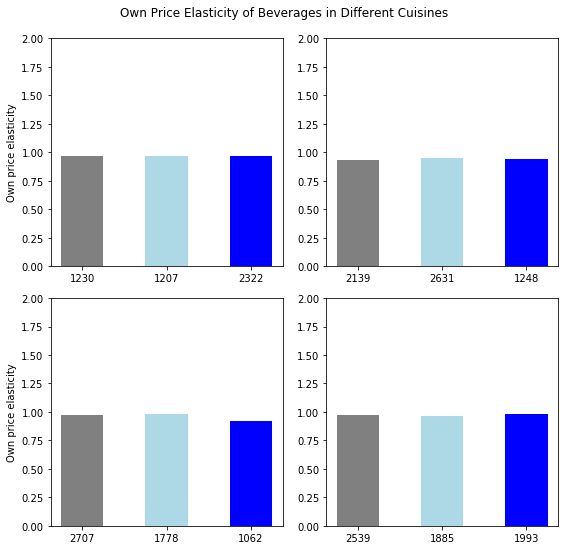

In [75]:
coeff_cont_1 = fit_cont_1207.params['log_unit_price_1207']
coeff_cont_2 = fit_cont_1230.params['log_unit_price_1230']
coeff_cont_3 = fit_cont_2322.params['log_unit_price_2322']
coeff_ita_1 = fit_ita_1062.params['log_unit_price_1062']
coeff_ita_2 = fit_ita_1778.params['log_unit_price_1778']
coeff_ita_3 = fit_ita_2707.params['log_unit_price_2707']
coeff_ind_1 = fit_ind_1248.params['log_unit_price_1248']
coeff_ind_2 = fit_ind_2139.params['log_unit_price_2139']
coeff_ind_3 = fit_ind_2631.params['log_unit_price_2631']
coeff_thai_1 = fit_thai_1885.params['log_unit_price_1885']
coeff_thai_2 = fit_thai_1993.params['log_unit_price_1993']
coeff_thai_3 = fit_thai_2539.params['log_unit_price_2539']


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
axes[0,0].bar(['1230', '1207', '2322'], np.abs([coeff_cont_1, coeff_cont_2, coeff_cont_3]), width = 0.5, color=['grey','lightblue','blue'])
axes[0,0].set_ylim([0,2])
#axes[0,0].set_xlabel("Continental meal_id")
axes[0,0].set_ylabel("Own price elasticity")
axes[0,1].bar(['2139','2631','1248'], np.abs([coeff_ind_1, coeff_ind_2, coeff_ind_3]), width = 0.5, color=['grey','lightblue','blue'])
axes[0,1].set_ylim([0,2])
#axes[0,1].set_xlabel("Indian meal_id")
axes[1,0].bar(['2707', '1778', '1062'], np.abs([coeff_ita_1, coeff_ita_2, coeff_ita_3]), width = 0.5, color=['grey','lightblue','blue'])
axes[1,0].set_ylim([0,2])
#axes[1,0].set_xlabel("Italian meal_id")
axes[1,0].set_ylabel("Own price elasticity")
axes[1,1].bar(['2539', '1885', '1993'], np.abs([coeff_thai_1, coeff_thai_2, coeff_thai_3]), width = 0.5, color=['grey','lightblue','blue'])
axes[1,1].set_ylim([0,2])
#axes[1,1].set_xlabel("Thai meal_id")
    
fig.suptitle("Own Price Elasticity of Beverages in Different Cuisines")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('img/own_elasticity.png')
plt.show()

In [76]:
[coeff_cont_1, coeff_cont_2, coeff_cont_3]

[-0.9701628896992494, -0.9701116982178549, -0.9645536519768467]

In [77]:
[coeff_ind_1, coeff_ind_2, coeff_ind_3]

[-0.9330523051070894, -0.9540944224902392, -0.9424782319248916]

In [78]:
[coeff_ita_1, coeff_ita_2, coeff_ita_3]

[-0.9720916309677745, -0.9841361665054861, -0.9221980866872773]

In [79]:
[coeff_thai_1, coeff_thai_2, coeff_thai_3]

[-0.9685943149406961, -0.967382730788504, -0.9846502176086014]

**Discussion:**
- We arranged the sequence of beverages in each cuisine by their rank of revenue contribution.
- We took the absolute value of own-price elasticity to plot the gragh.
    - For Continental cuisine, the own-price elasticity of each beverage is: [1230: -0.97], [1207: -0.97], [2322: -0.96]
    - For Indian cuisine, the own-price elasticity of each beverage is: [2139: -0.93], [2631: -0.95], [1248: -0.94]
    - For Italian cuisine, the own-price elasticity of each beverage is: [2707: -0.97], [1778: -0.98], [1062: -0.92]
    - For Thai cuisine, the own-price elasticity of each beverage is: [2539: -0.97], [1885: -0.97], [1993: -0.98]
- All own-price elasticity in each cuisine are very close to 1 (inelastic), which means customers are less sensitive to the price change of beverages.
- Generally, Indian beverages have slightly lower own-price elasticity than other cuisines, which is consistent with our intuition from the demand curve.

### Cross-Price Elasticity Visualization

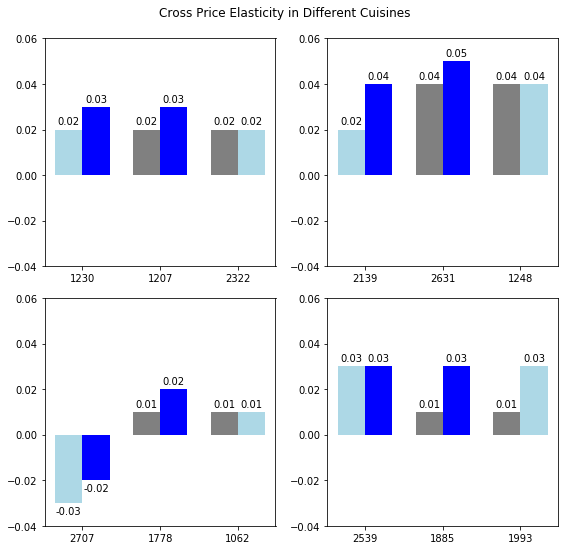

In [80]:
coeff_cont_1230_1207 = fit_cont_1207.params['log_unit_price_1230']
coeff_cont_2322_1207 = fit_cont_1207.params['log_unit_price_2322']
coeff_cont_1207_1230 = fit_cont_1230.params['log_unit_price_1207']
coeff_cont_2322_1230 = fit_cont_1230.params['log_unit_price_2322']
coeff_cont_1207_2322 = fit_cont_2322.params['log_unit_price_1207']
coeff_cont_1230_2322 = fit_cont_2322.params['log_unit_price_1230']
coeff_ita_1778_1062 = fit_ita_1062.params['log_unit_price_1778']
coeff_ita_2707_1062 = fit_ita_1062.params['log_unit_price_2707']
coeff_ita_1062_1778 = fit_ita_1778.params['log_unit_price_1062']
coeff_ita_2707_1778 = fit_ita_1778.params['log_unit_price_2707']
coeff_ita_1062_2707 = fit_ita_2707.params['log_unit_price_1062']
coeff_ita_1778_2707 = fit_ita_2707.params['log_unit_price_1778']
coeff_ind_2139_1248 = fit_ind_1248.params['log_unit_price_2139']
coeff_ind_2631_1248 = fit_ind_1248.params['log_unit_price_2631']
coeff_ind_1248_2139 = fit_ind_2139.params['log_unit_price_1248']
coeff_ind_2631_2139 = fit_ind_2139.params['log_unit_price_2631']
coeff_ind_1248_2631 = fit_ind_2631.params['log_unit_price_1248']
coeff_ind_2139_2631 = fit_ind_2631.params['log_unit_price_2139']
coeff_thai_1993_1885 = fit_thai_1885.params['log_unit_price_1993']
coeff_thai_2539_1885 = fit_thai_1885.params['log_unit_price_2539']
coeff_thai_1885_1993 = fit_thai_1993.params['log_unit_price_1885']
coeff_thai_2539_1993 = fit_thai_1993.params['log_unit_price_2539']
coeff_thai_1885_2539 = fit_thai_2539.params['log_unit_price_1885']
coeff_thai_1993_2539 = fit_thai_2539.params['log_unit_price_1993']

labels_cont = ['1230','1207', '2322']
coeff_cont_1 = np.round([coeff_cont_1207_1230, coeff_cont_1230_1207, coeff_cont_1207_2322], 2)
coeff_cont_2 = np.round([coeff_cont_2322_1230, coeff_cont_2322_1207, coeff_cont_1230_2322], 2)

labels_ind = ['2139', '2631', '1248']
coeff_ind_1 = np.round([coeff_ind_2631_2139, coeff_ind_2139_2631, coeff_ind_2631_1248], 2)
coeff_ind_2 = np.round([coeff_ind_1248_2139, coeff_ind_1248_2631, coeff_ind_2139_1248], 2)

labels_ita = ['2707', '1778', '1062']
coeff_ita_1 = np.round([coeff_ita_1062_2707, coeff_ita_2707_1778, coeff_ita_1778_1062], 2)
coeff_ita_2 = np.round([coeff_ita_1778_2707, coeff_ita_1062_1778, coeff_ita_2707_1062], 2)

labels_thai = ['2539', '1885', '1993']
coeff_thai_1 = np.round([coeff_thai_1885_2539, coeff_thai_2539_1885, coeff_thai_2539_1993], 2)
coeff_thai_2 = np.round([coeff_thai_1993_2539, coeff_thai_1993_1885, coeff_thai_1885_1993], 2)

x = np.arange(len(labels_cont))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
rects_cont_1 = ax[0,0].bar(x - width/2, coeff_cont_1, width, color=['lightblue','grey','grey'])
rects_cont_2 = ax[0,0].bar(x + width/2, coeff_cont_2, width, color= ['blue','blue','lightblue'])
rects_ind_1 = ax[0,1].bar(x - width/2, coeff_ind_1, width, color=['lightblue','grey','grey'])
rects_ind_2 = ax[0,1].bar(x + width/2, coeff_ind_2, width, color= ['blue','blue','lightblue'])
rects_ita_1 = ax[1,0].bar(x - width/2, coeff_ita_1, width, color=['lightblue','grey','grey'])
rects_ita_2 = ax[1,0].bar(x + width/2, coeff_ita_2, width, color= ['blue','blue','lightblue'])
rects_thai_1 = ax[1,1].bar(x - width/2, coeff_thai_1, width, color=['lightblue','grey','grey'])
rects_thai_2 = ax[1,1].bar(x + width/2, coeff_thai_2, width, color= ['blue','blue','lightblue'])

# add some text for labels, title and custom x-axis tick labels, etc.
fig.suptitle('Cross Price Elasticity in Different Cuisines')
ax[0,0].set_xticks(x)
ax[0,1].set_xticks(x)
ax[1,0].set_xticks(x)
ax[1,1].set_xticks(x)
ax[0,0].set_xticklabels(labels_cont)
ax[0,1].set_xticklabels(labels_ind)
ax[1,0].set_xticklabels(labels_ita)
ax[1,1].set_xticklabels(labels_thai)

ax[0,0].set_ylim([-0.04, 0.06])
ax[0,1].set_ylim([-0.04, 0.06])
ax[1,0].set_ylim([-0.04, 0.06])
ax[1,1].set_ylim([-0.04, 0.06])

def autolabel(rects, row, col):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height < 0:
            offset = -13
        else:
            offset = 3
        ax[row,col].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects_cont_1, 0, 0)
autolabel(rects_cont_2, 0, 0)
autolabel(rects_ind_1, 0, 1)
autolabel(rects_ind_2, 0, 1)
autolabel(rects_ita_1, 1, 0)
autolabel(rects_ita_2, 1, 0)
autolabel(rects_thai_1, 1, 1)
autolabel(rects_thai_2, 1, 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('img/cross_elasticity.png')
plt.show()

**Discussion:**<br>
- For easily recognizing which bar shows the cross price elasticity of which beverage, we differentiated the bars by 3 colors in each cuisine. We arranged the sequence of beverages in each cuisine by their rank of revenue contribution.
    - For Continental cuisine (upper-left corner): grey[1230], light blue[1207], dark blue[2322].
    - For Indian cuisine (upper-right corner): grey[2139], light blue[2631], dark blue[1248].
    - For Italian cuisine (lower-left corner): grey[2707], light blue[1778], dark blue[1062].
    - For Thai cuisine (lower-right corner): grey[2539], light blue[1885], dark blue[1993].
- All cross price elasticity are low. The absolute value of cross price elasticity is in the range of 0.02 to 0.05, which tells us the demand of a certain beverage is not affected much by the prices of other beverages in the same cuisine. This conclusion also provides us with some intuition about how to build the demand prediction model (we don't have to consider the price of other products in the demand prediction model of a certain product, only the price of itself can influence the demand).
- The majority of the cross price elasticity are positive, only the cross price elasticity of Italian 2707 has negative value. Since we don't know the actual product name, we guess it is a companion drink with other drink such as Tonic water with Vodka, and Coke with Whisky, lemonade with black tea. 

## 6 Demand Prediction

- In this section, we want to build three models to predict demand and to see which one gives the best prediction. We will go though *Data Processing*, *Optimal Model Selection* and *Model Performances on Test Set*

### 6.1 Data Processing

**Step 1: Convert the price and demand data to log space** 

Get log numbers of demand and unit price of the beverage for all centr-weeks in order to use multi-linear regression model for demand prediction.

**Step 2: Drop unnnecessary columns**

Drop unnnecessary columns "id", "num_orders" and "unit_price" to prepare dataframe for building linear regressopm model.

**Step 3: Data type Conversion.** 

We want to change the data type of 'meal_id' and 'center_id' from continuous variables to categorical variables in order to encode these two variables in our multi-linear regression models in the later part.

In [81]:
beverages_log = beverages.copy() # make a copy of the data set to avoid changing the previous data frame.
beverages_log['log_num_orders'] = np.log(beverages['num_orders'])
beverages_log['log_unit_price'] = np.log(beverages['unit_price'])
beverages_log.drop(['id','num_orders','unit_price'], axis = 1, inplace = True)
beverages_log.head()

,week,center_id,meal_id,category,cuisine,log_num_orders,log_unit_price
0,1,55,1885,Beverages,Thai,5.176150,-0.150363
1,1,55,1993,Beverages,Thai,5.598422,-0.687018
2,1,55,2539,Beverages,Thai,5.241747,-0.330122
3,1,55,2139,Beverages,Indian,3.988984,2.092161
4,1,55,2631,Beverages,Indian,3.688879,1.802122


In [82]:
beverages_log['meal_id'] = beverages_log['meal_id'].astype('category')
beverages_log['center_id'] = beverages_log['center_id'].astype('category')
beverages_log.dtypes

week                 int64
center_id         category
meal_id           category
category            object
cuisine             object
log_num_orders     float64
log_unit_price     float64
dtype: object

### 6.2 Optimal Model Selection

In this Part, we are going to build three models and select the optimal one.

#### Model 1

- We are going to build our first model to only consider *Price*. In previous demand curves, we can see that we got similar demand patterns for all cusine types so that we want to check how unit price affect the demand.

#### Model 2 

- We are going to add *cuisine* to our second model based on the first one because we also want to check if the type of cuisine also plays a role in predicting demand.

#### Model 3

- We want to improve our model by introducing *Meal_ID* and *Center_ID* to see if we can get deeper insights in predicting demand.

#### We use $R^2$ and MSE to evaluate our model performance:

- R_squared (R2) , which is the proportion of variation in the outcome that is explained by the predictor variables.

- Mean Squared Error (MSE), which measures the average error performed by the model in predicting the outcome for an observation.

### 6.2.1 Model 1

#### $log(Q) $~$ log(P)$

In this model, we only include the own unit price since the cross price elasticities among differnet meal products are very small, which has been shown from the previous part.

#### Determine and assign *dependent variable* and *independent variable(s)*

In [83]:
X = beverages_log['log_unit_price'].to_numpy().reshape(-1, 1)
Y = beverages_log['log_num_orders'].to_numpy()

#### We split the train and test set at the ratio of 70/30 and set seed using *random_state* at *42* to ensure that we got the same split of the train/test set no matter how many times we re-visit the model.

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

#### We try to fit the linear regression model on the train set

In [85]:
beverages_all_model = LinearRegression()
beverages_all_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### We check coefficient(s) of independent variable(s)

In [86]:
beverages_all_model.coef_

array([-0.80918214])

#### We apply Model 1 to predict demand on the test set

In [87]:
y_pred_model_1 = beverages_all_model.predict(X_test)

#### We evaluate Model 1 using R-Square and MSE (Mean Square Error)

In [88]:
r2_score(Y_test, y_pred_model_1)

0.9062616146652035

In [89]:
mean_squared_error(Y_test, y_pred_model_1)

0.11514439193127066

### 6.2.2 Model 2

#### $log(Q) $~$ log(P) + C(cuisine) $

**Step 1:** Determine *dependent variable* and *independent variable(s)*

**Step 2:** Take *log_unit_price* and *cuisine* as independent variables

**Step 3:** Encode categorical variable(s) using *get_dummies* for "cuisine"

**Step 4:** Take *log_num_orders* as dependent variable

In [90]:
X = beverages_log[['log_unit_price', 'cuisine']]
X = pd.get_dummies(data = X, drop_first=True)
print(X.head())
Y = beverages_log['log_num_orders'].to_numpy()

   log_unit_price  cuisine_Indian  cuisine_Italian  cuisine_Thai
0       -0.150363               0                0             1
1       -0.687018               0                0             1
2       -0.330122               0                0             1
3        2.092161               1                0             0
4        1.802122               1                0             0


#### We split the train and test set at the ratio of 70/30 and set seed using *random_state* at *42* to ensure that we got the same split of the train/test set no matter how many times we re-visit the model.

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

#### We try to fit the linear regression model on the train set

In [92]:
beverages_model = LinearRegression()
beverages_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### We check the coefficient(s) of independent variable

In [93]:
beverages_model.coef_

array([-0.91690385, -0.58234399, -0.51671476, -0.87121166])

#### We apply Model 2 to predict demand on the test set

In [94]:
y_pred_model_2 = beverages_model.predict(X_test)

#### We evaluate Model 2 using R-Square and MSE (Mean Square Error)

In [95]:
r2_score(Y_test, y_pred_model_2)

0.9674665811222497

In [96]:
mean_squared_error(Y_test, y_pred_model_2)

0.03996271880238277

### 6.2.3 Model 3

#### $log(Q) \sim log(P) + C(meal\_id) + C(center\_id)$

- We revisited *beverage_log* dataframe and keep all variables in model 3 except for dropping *cuisine*. The reason why we drop *cuisine* is because cuisine type has already been reflected by Meal_ID. Also we encode categorical variable(s) using *get_dummies* for *meal_id* and *center_id*

In [97]:
full_table = pd.get_dummies(data=beverages_log.drop('cuisine', axis = 1), drop_first=True)

#### Determine *dependent variable* and *independent variable(s)*
-  Take *log_unit_price*,*Meal_ID* and *Center_ID* as independent variables
-  Take *log_num_orders* as dependent variable

In [98]:
X = full_table.drop('log_num_orders', axis = 1)
Y = full_table['log_num_orders']

#### We split the train and test set at the ratio of 70/30 and set seed using *random_state* at *42* to ensure that we got the same split of the train/test set no matter how many times we re-visit the model.

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

#### We fit linear regression model on the train set and have a glance at coefficients

In [100]:
mlr_1 = LinearRegression()
mlr_1.fit(X_train, Y_train)
mlr_1.coef_

array([-4.39893303e-04, -9.35915485e-01, -2.06321321e-02,  1.74667129e-03,
       -4.49745476e-02, -5.63184885e-02, -4.67142983e-02, -4.86534455e-02,
       -2.46327298e-03, -1.91820315e-01, -3.48457197e-02, -2.09604108e-01,
       -4.20591445e-02, -1.81585163e-01, -2.06719467e-01, -4.99134706e-02,
       -2.09032002e-01, -8.80199053e-02, -1.95815024e-01,  1.71115894e-02,
       -1.61806075e-01, -3.04010950e-02,  3.27552778e-03, -6.04191004e-02,
       -7.99054714e-02, -2.03516703e-01, -1.98201193e-01, -4.49819731e-02,
       -1.84673209e-01, -1.93010070e-01, -1.73520266e-01, -1.75367185e-01,
       -1.85419971e-02, -1.98327459e-01, -3.96403514e-02, -2.11504476e-01,
       -2.11389513e-01, -1.42798886e-01, -5.45972671e-02, -2.10713417e-01,
       -3.20910718e-02, -1.89025267e-01, -1.53167743e-01, -4.84262474e-02,
       -1.98589036e-01, -3.28827450e-02, -1.14032392e-01, -2.24461349e-01,
       -1.98768707e-01, -2.00827897e-01, -1.51133703e-01, -2.12343739e-02,
       -3.59266671e-02, -

#### We try to predict demand on the test set

In [101]:
y_pred_model_3 = mlr_1.predict(X_test)

#### We evaluate Model 3 using R-Square and MSE (Mean Square Error)

In [102]:
mlr_1.score(X_train, Y_train)

0.9889064805713299

#### We evaluate Model 3 using R-Square and MSE (Mean Square Error)

In [103]:
r2_score(Y_test, y_pred_model_3)

0.9887927478686559

In [104]:
mean_squared_error(Y_test, y_pred_model_3)

0.013766529338808967

### Here is the summary of the performance of three models:

<img src="img/model.png">

### Conclusions:
#### We select model 2 as the optimal Model for Demand Prediction. 
#### The reasons why we made this selection is:
1. Based on what the above table has shown, Model 2 has a generally good fit, and it only includes the price and cuisine type, which is more generalized. If the food company wants to explore the new menu, they can easily leverage the results from Model 2 to have a good prediction on the demand.
2. Although model 3 also shows a good fit even better than model 2, we don't take it as our first choice since this model is less generalize that we can not utilize the results for practice. In addition, the improvement of R-square is not that significant enough for us to switch to Model 3.

### 6.3 Model Performances on Test Data

**Step 1:** We apply 3 models to the first 10 rows from test set to get the predicted log demands *model_1*, *model_2*, *model_3* 
**Step 2:** We get the true log demand of the first 10 rows from test set *true_y*
**Step 3:** We also get the price of the first 10 rows from test set and save it as *true_x*

In [105]:
# Model 1 Predicted log Demand of the first 10 rows from test set
model_1 = y_pred_model_1[:10]

# Model 2 Predicted log Demand of the fisrt 10 rows from test set
model_2 = y_pred_model_2[:10]

# Model 3 Predicted log Demand of the first 10 rows from test set
model_3 = y_pred_model_3[:10]

# Actual log Demand of the first 10 rows from test set
true_y = np.array(Y_test[:10])

# The exponential of the log_unit_price (the true price) of the first 10 rows from test set and round to 2 decimal points
true_x = np.array(np.round_(np.exp(X_test['log_unit_price'][:10]),2))

### Save the above variables into a dataframe:
*test_sample*

In [106]:
test_sample = pd.DataFrame({'true_x': true_x,'true_y': true_y, 'model_1': model_1, 'model_2': model_2, 'model_3': model_3})

In [107]:
test_sample.sort_values('true_x', inplace = True)

In [108]:
test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 9 to 7
Data columns (total 5 columns):
true_x     10 non-null float64
true_y     10 non-null float64
model_1    10 non-null float64
model_2    10 non-null float64
model_3    10 non-null float64
dtypes: float64(5)
memory usage: 480.0 bytes


### Plot *test_sample* to have a rough look at the different performances for these three models ont the test set and compare the predicted log-demands witht the actual log-demands.

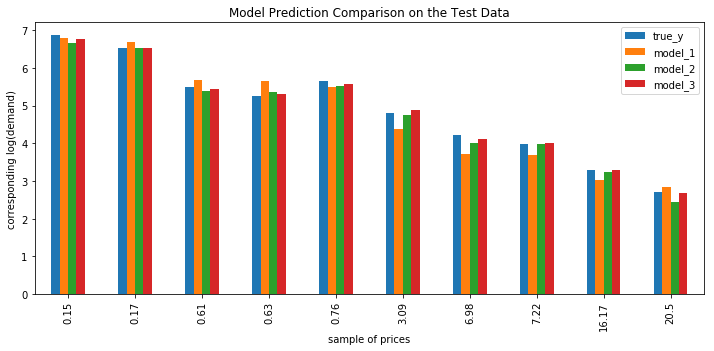

In [109]:
test_sample.plot(x = 'true_x', y = ['true_y', 'model_1', 'model_2', 'model_3'], kind='bar', figsize = (12,5), title="Model Prediction Comparison on the Test Data")
plt.xlabel('sample of prices')
plt.ylabel('corresponding log(demand)')
plt.savefig('model_comparison_log.png')
plt.show()

### After taking look at the Model prediction Comparison on the Test Data by using log-demand as y-variable, we replace the log-demand with demand.
### Re-assign variables by taking exponential of the log-demand, which is *demand*

In [110]:
# Model 1 Predicted Demand (takeing exponential of the log-demand) of the first 10 rows from test set
model_1 = np.exp(y_pred_model_1[:10])

# Model 2 Predicted Demand (takeing exponential of the log-demand) of the first 10 rows from test set
model_2 = np.exp(y_pred_model_2[:10])

# Model 3 Predicted Demand (takeing exponential of the log-demand) of the first 10 rows from test set
model_3 = np.exp(y_pred_model_3[:10])

# Actual Demand (takeing exponential of the log-demand) of the first 10 rows from test set
true_y = np.exp(np.array(Y_test[:10]))

# The exponential of the log_unit_price (the true price) of the first 10 rows from test set and round to 2 decimal points
true_x = np.array(np.round_(np.exp(X_test['log_unit_price'][:10]),2))

### Save the above variables into a dataframe:
*test_sample*

In [111]:
test_sample = pd.DataFrame({'true_x': true_x,'true_y': true_y, 'model_1': model_1, 'model_2': model_2, 'model_3': model_3})

In [112]:
test_sample.sort_values('true_x', inplace = True)

In [113]:
test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 9 to 7
Data columns (total 5 columns):
true_x     10 non-null float64
true_y     10 non-null float64
model_1    10 non-null float64
model_2    10 non-null float64
model_3    10 non-null float64
dtypes: float64(5)
memory usage: 480.0 bytes


### Plot *test_sample* to have a rough look at the differet performances for these three models on the test set and compare the predicted demands witht the actual demands.

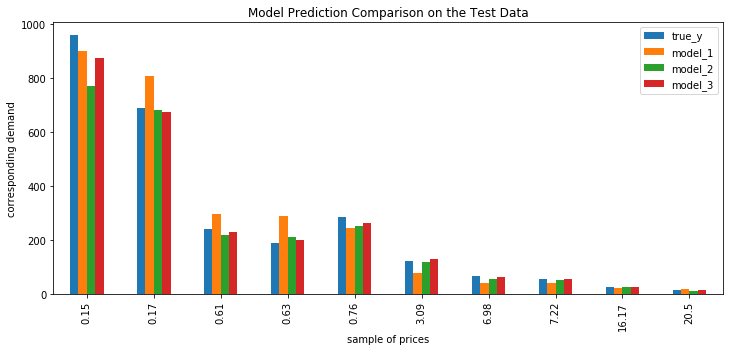

In [114]:
test_sample.plot(x = 'true_x', y = ['true_y', 'model_1', 'model_2', 'model_3'], kind='bar', figsize = (12,5), title="Model Prediction Comparison on the Test Data")
plt.xlabel('sample of prices')
plt.ylabel('corresponding demand')
plt.savefig('model_comparison.png')
plt.show()

### Conclusions: 
The first plot uses the log(demand) as y-variable while the second plot uses the demand as y-variable. Comparing these two plots, the log(demand) plot has less discrepancies in the low-price/high-demand region than the demand plot, which is because the difference of the demand in log-scale will be amplified in normal scale, especially when the demad is high.

## 7 How to maximize the profit for each cuisine

### We have made two assumptions in this section:

1. We assume the best price is the same for all producs for each cuisine. We make this assumption based on the four demand curves we created in the previous part. As we can see, the demand curve of all three prducts almost clustered together in each cuisine type, which means that all the three products in the same cuisine type have almost similar pattern in terms of the interaction of demand and price. 

1. We assume the Cost for the (soft) beverages are 20% of the average price for each cuisine.
(https://www.touchbistro.com/blog/how-to-calculate-your-cost-of-goods-sold/). We also asusme the beverages are made to order at the location, like bubble tea. We don't consider the retial margin here.

### Load data for each cusine type 

In [115]:
continental_data = beverages[beverages['cuisine'] == 'Continental']
indian_data = beverages[beverages['cuisine'] == 'Indian']
italian_data = beverages[beverages['cuisine'] == 'Italian']
thai_data = beverages[beverages['cuisine'] == 'Thai']

### Assign *cost* variable for each of the cusine type based on the second assumption we made

In [116]:
continental_cost = continental_data['unit_price'].mean() * 0.20
indian_cost = indian_data['unit_price'].mean() * 0.20
italian_cost = italian_data['unit_price'].mean() * 0.20
thai_cost = thai_data['unit_price'].mean() * 0.20

In [117]:
# log_unit_price,  cuisine_Indian,  cuisine_Italian,  cuisine_Thai
print(beverages_model.intercept_, beverages_model.coef_)

5.795585904472209 [-0.91690385 -0.58234399 -0.51671476 -0.87121166]


## 1. Best Price for Continental Cuisine

**Step 1:** Get customer puchasing probability at a given price range by dividing order quantity at that price range by total order quantity for Continental Cuisine.

**Step 2:** Use exponential function (PDF) to describe the customer behavior of purchasing probability

### $Probability = \lambda \cdot exp( - \lambda \cdot Price)$
                      
**Step 3:** Based on the optimal model, we want to find the best price to maximize the adjusted profit 

### $ Adj Profit = Profit \cdot Probability $

where, 

$ Profit = Demand(model$_$2) \cdot (Price - Cost) $

$ Probability = \lambda \cdot exp ( - \lambda* Price) $

In [118]:
## Take a look at the data description for "num_ordrs" and "unit_price" columns
continental_data[['num_orders','unit_price']].describe()

,num_orders,unit_price
count,27549.000000,27549.000000
mean,147.795891,4.669765
std,106.654788,5.516048
min,13.000000,0.224212
25%,69.000000,1.779078
50%,123.000000,2.867647
75%,202.000000,4.921042
max,2120.000000,40.963846


In [119]:
## Group by "unit_price" and count the "num_orders" at that price point
continental_freq = continental_data.groupby('unit_price')['num_orders'].sum().reset_index()
continental_freq.head()

,unit_price,num_orders
0,0.224212,2120
1,0.282101,1661
2,0.287101,1311
3,0.303952,1283
4,0.318221,1012


### Use function "freq" to get the past purchasing probability at a given price range for continental cuisine and plot the histogram

In [120]:
freq = []
for i,j in enumerate(continental_freq['unit_price']):
    #print(i,j)
    for k in range(continental_freq['num_orders'][i]):
        freq.append(j)

(array([3.00122124e-01, 2.62641990e-01, 9.08726318e-02, 3.54635756e-02,
        1.96685881e-02, 8.70303195e-03, 6.74561388e-03, 1.41231430e-03,
        3.94341158e-03, 1.26943707e-03, 8.92892266e-04, 2.43433865e-04,
        1.40779287e-03, 7.38621028e-04, 1.49930664e-04, 2.27880141e-04,
        2.37827290e-04, 8.37369089e-05, 2.63328163e-04, 7.52366179e-05,
        1.52100951e-04, 1.00737491e-04, 1.88814974e-04, 1.43419803e-04,
        2.32039858e-04, 7.68643332e-05, 2.53381014e-04, 1.17557215e-05,
        4.23205976e-05, 1.88091545e-05]),
 array([ 0.22421226,  1.58220006,  2.94018786,  4.29817565,  5.65616345,
         7.01415125,  8.37213904,  9.73012684, 11.08811463, 12.44610243,
        13.80409023, 15.16207802, 16.52006582, 17.87805362, 19.23604141,
        20.59402921, 21.95201701, 23.3100048 , 24.6679926 , 26.02598039,
        27.38396819, 28.74195599, 30.09994378, 31.45793158, 32.81591938,
        34.17390717, 35.53189497, 36.88988276, 38.24787056, 39.60585836,
        40.96384

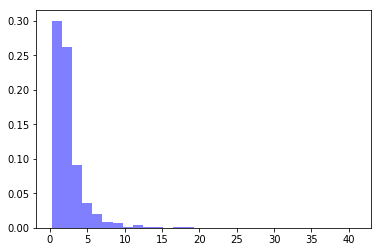

In [121]:
plt.hist(np.array(freq),30, facecolor='blue', alpha=0.5, density= True)

### Use exponential distribution to fit the customer history purchasing behavior for Continental cusine

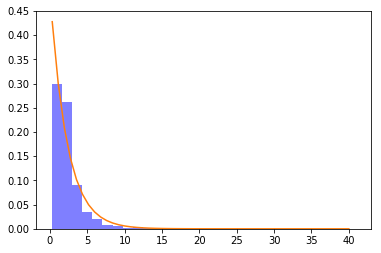

In [122]:
P = expon.fit(np.array(freq))
rX = np.linspace(0.3,40)
rP = expon.pdf(rX, *P)
plt.hist(np.array(freq),30, facecolor='blue', alpha=0.5, density = True)
plt.plot(rX,rP)

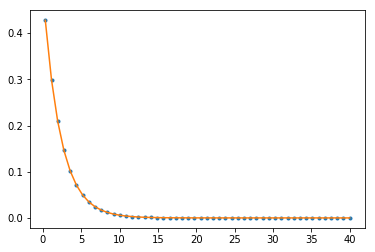

In [123]:
p = np.linspace(0.3,40)
plt.plot(p ,1/P[1] * np.exp(-1/P[1]*(p-P[0])), '.')
plt.plot(p,expon.pdf(p, *P))

In [124]:
def continental_profit(P_continental):
    profit_continental = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(P_continental)) * (P_continental - continental_cost)
    return -profit_continental

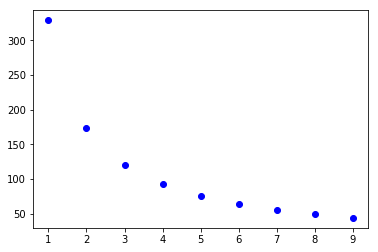

In [125]:
p = np.arange(1, 10)
plt.plot(p, np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(p)), 'bo')

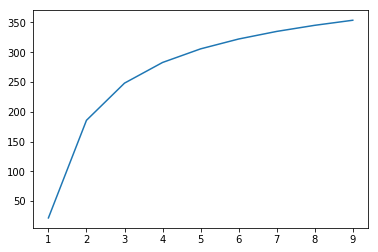

In [126]:
p = np.arange(1, 10)
plt.plot(p, -continental_profit(p))

There is no obvious asymptotic line, the profit is just keep increasing. we need to consider the probablity of the purchase for each price region.  

### We found out that the max profit will appear at the bound

In [127]:
continental_data['unit_price'].mean() * 0.9, continental_data['unit_price'].mean(), continental_data['unit_price'].mean() * 1.1

(4.202788182940264, 4.669764647711404, 5.136741112482545)

In [128]:
bounds = Bounds(continental_data['unit_price'].mean() * 0.9, continental_data['unit_price'].mean() * 1.1)

In [129]:
def continental_profit(P_continental):
    profit_continental = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(P_continental)) * (P_continental - continental_cost)
    return -profit_continental

In [130]:
res = minimize(continental_profit, continental_data['unit_price'].mean(), method='trust-constr', bounds=bounds).x

In [131]:
res

array([5.13652262])

In [132]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res))

array([73.3458673])

We need to consider the probability of the purchase behavior. i.e., although high price can tend to have max profit, it is unlikely to happen according to the past transaction history.

### Considering past purchasing probability to get the adjusted profit function

In [133]:
def profit_cont(price):
    profit = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(price)) * (price - continental_cost)
    purchase_prob = 1 / P[1] * np.exp(- 1 / P[1] * (price - P[0]))
    purchase_prob[purchase_prob > 1] = 0.99 # set 0.99 if the expon fit is greater than 1
    return -profit * purchase_prob

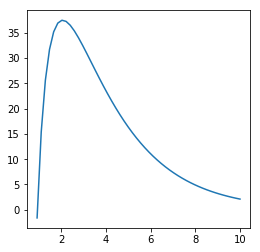

In [134]:
plt.figure(figsize=(4,4))
p = np.linspace(0.92,10)
plt.plot(p, -profit_cont(p))
plt.savefig('cont_optimal')

### Find the best price and optimal profit for Continentl Cuisine

In [135]:
res = minimize(profit_cont, continental_data['unit_price'].mean(), method='nelder-mead').x

In [136]:
res # best price

array([2.06097828])

In [137]:
-profit_cont(res) # optimal profit

array([37.48580608])

In [138]:
np.exp(beverages_all_model.intercept_ + beverages_all_model.coef_[0] * np.log(res)) # expected demand

array([109.56775066])

In [139]:
1 / P[1] * np.exp(- 1 / P[1] * (res - P[0])) #prob

array([0.19629865])

In [140]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res)) * (res - continental_cost) # Q*(P-C)

array([190.96313681])

## 2. Same analysis on the best price for Indian Cusine

In [141]:
indian_data[['num_orders','unit_price']].describe()

,num_orders,unit_price
count,26069.000000,26069.000000
mean,68.101730,6.648915
std,63.604567,6.924143
min,13.000000,0.112325
25%,27.000000,1.928250
50%,53.000000,3.786829
75%,82.000000,9.589231
max,2323.000000,35.148462


In [142]:
indian_freq = indian_data.groupby('unit_price')['num_orders'].sum().reset_index()

In [143]:
freq = []
for i, j in enumerate(indian_freq['unit_price']):
    for k in range(indian_freq['num_orders'][i]):
        freq.append(j)

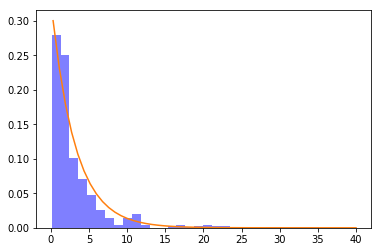

In [144]:
P = expon.fit(np.array(freq))
rX = np.linspace(0.3,40)
rP = expon.pdf(rX, *P)
plt.hist(np.array(freq),30, facecolor='blue', alpha=0.5, density=True)
plt.plot(rX,rP)

In [145]:
def profit(P_indian):
    profit_indian = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(P_indian) + beverages_model.coef_[1]) * (P_indian - indian_cost)
    purchase_prob = 1 / P[1] * np.exp(- 1 / P[1] * (P_indian - P[0]))
    purchase_prob[purchase_prob > 1] = 0.99 # set 0.99 if the expon fit is greater than 1
    return -profit_indian * purchase_prob

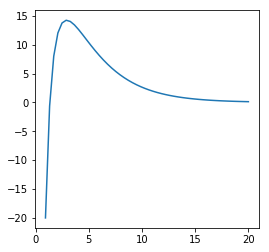

In [146]:
plt.figure(figsize=(4,4))
p = np.linspace(0.92,20)
plt.plot(p, -profit(p))
plt.savefig('ind_optimal')

### Find the best price and optimal value for indian cuisine

In [147]:
res = minimize(profit, indian_data['unit_price'].mean(), method='nelder-mead').x

In [148]:
res # best price

array([2.90622202])

In [149]:
-profit(res) # optimal profit

array([14.24405085])

In [150]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[1]) # expected demand

array([69.06440039])

In [151]:
1 / P[1] * np.exp(- 1 / P[1] * (res - P[0])) #prob

array([0.13082842])

In [152]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[1]) * (res - indian_cost) # Q*(P-C)

array([108.87581257])

## 3. Same analysis on the best price for Italian Cusine

In [153]:
italian_data[['num_orders','unit_price']].describe()

,num_orders,unit_price
count,31259.000000,31259.000000
mean,403.700310,0.876341
std,318.893015,1.081761
min,13.000000,0.063687
25%,188.000000,0.359981
50%,312.000000,0.591796
75%,514.000000,1.003068
max,3483.000000,18.656154


In [154]:
italian_freq = italian_data.groupby('unit_price')['num_orders'].sum().reset_index()
italian_freq.head()

,unit_price,num_orders
0,0.063687,2970
1,0.065007,2850
2,0.066569,3483
3,0.067381,2822
4,0.069020,2755


In [155]:
freq = []
for i, j in enumerate(italian_freq['unit_price']):
    for k in range(italian_freq['num_orders'][i]):
        freq.append(j)

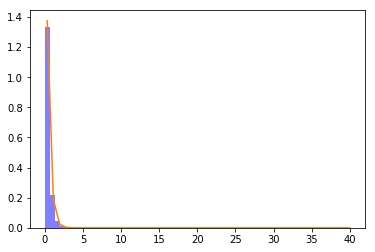

In [156]:
P = expon.fit(np.array(freq))
rX = np.linspace(0.3,40)
rP = expon.pdf(rX, *P)
plt.hist(np.array(freq),30, facecolor='blue', alpha=0.5, density= True)
plt.plot(rX,rP)

In [157]:
def profit(price):
    profit = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(price) + beverages_model.coef_[2]) * (price - italian_cost)
    purchase_prob = 1 / P[1] * np.exp(- 1 / P[1] * (price - P[0]))
    purchase_prob[purchase_prob > 1] = 0.99 # set 0.99 if the expon fit is greater than 1
    return -profit * purchase_prob

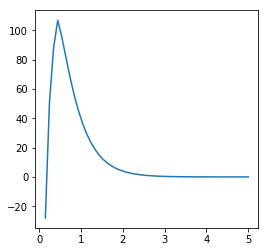

In [158]:
plt.figure(figsize=(4,4))
p = np.linspace(0.15,5)
plt.plot(p, -profit(p))
plt.savefig('ita_optimal')

### Find the best price and optimal value for Italian Cuisine

In [159]:
res = minimize(profit, italian_data['unit_price'].mean(), method='nelder-mead').x

In [160]:
res # best price

array([0.42957769])

In [161]:
-profit(res) # optimal profit

array([108.24568059])

In [162]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[2]) # expected demand

array([425.64748503])

In [163]:
1 / P[1] * np.exp(- 1 / P[1] * (res - P[0])) #prob

array([0.99999522])

In [164]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[2]) * (res - italian_cost) # Q*(P-C)

array([108.24619854])

## 4. Same analysis on the best price for Thai Cusine

In [165]:
thai_data[['num_orders','unit_price']].describe()

,num_orders,unit_price
count,24273.000000,24273.000000
mean,446.639888,0.693765
std,410.398895,1.085209
min,13.000000,0.012232
25%,176.000000,0.223194
50%,337.000000,0.377634
75%,582.000000,0.714110
max,9045.000000,12.763846


In [166]:
thai_freq = thai_data.groupby('unit_price')['num_orders'].sum().reset_index()

In [167]:
freq = []
for i, j in enumerate(thai_freq['unit_price']):
    for k in range(thai_freq['num_orders'][i]):
        freq.append(j)

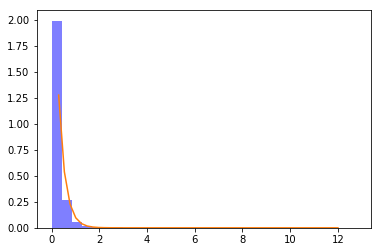

In [168]:
P = expon.fit(np.array(freq))
rX = np.linspace(0.3,12)
rP = expon.pdf(rX, *P)
plt.hist(np.array(freq),30, facecolor='blue', alpha=0.5, density =True)
plt.plot(rX,rP)

In [169]:
beverages_model.coef_, thai_cost

(array([-0.91690385, -0.58234399, -0.51671476, -0.87121166]),
 0.13875290956871011)

In [170]:
def profit(price):
    profit = np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(price) + beverages_model.coef_[3]) * (price - thai_cost)
    purchase_prob = 1 / P[1] * np.exp(- 1 / P[1] * (price - P[0]))
    purchase_prob[purchase_prob > 1] = 0.99 # set 0.99 if the expon fit is greater than 1
    return -profit * purchase_prob

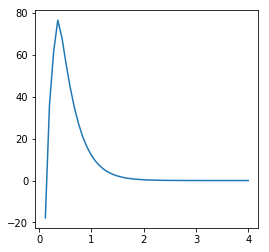

In [171]:
plt.figure(figsize=(4,4))
p = np.linspace(0.12,4)
plt.plot(p, -profit(p))
plt.savefig('thai_optimal')

### Find the best price and optimal value for Thai Cusine

In [172]:
res = minimize(profit, thai_data['unit_price'].mean(), method='nelder-mead').x

In [173]:
res # best price

array([0.36778858])

In [174]:
-profit(res) # optimal profit

array([78.85625052])

In [175]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[3]) # expected demand

array([344.29697479])

In [176]:
1 / P[1] * np.exp(- 1 / P[1] * (res - P[0])) #prob

array([0.99999952])

In [177]:
np.exp(beverages_model.intercept_ + beverages_model.coef_[0] * np.log(res) + beverages_model.coef_[3]) * (res - thai_cost) # Q*(P-C)

array([78.85628808])

### Conclusions:

<img src="img/profit.png">

We recommend the food dlivery company to cut down the price about the half to get the maximum profit considering the past customer behavior.